## Step 8: Reanalysis of mouse single-cell RNA-seq data from Wheeler et al

In this step, we'll examine the mouse EAE single-cell RNA-seq data originally from [Wheeler et al 2020 (PMID: 32051591)](https://pubmed.ncbi.nlm.nih.gov/32051591/).

We will use a preprocessed Seurat object provided to us by the authors of Lee et al, which contains their cluster labels.

In [1]:
library(Seurat)
library(readxl)
library(ggplot2)
library(ggpubr)
library(ggsci)
library(dplyr)
library(Nebulosa)
library(viridis)
library(presto)
library(ggrepel)
library(ggrastr)
library(cowplot)
setwd('..') # changing working directory to 'EpiMemAstros' folder

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: patchwork

Loading required package: viridisLite

Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots


The following object is masked from ‘package:ggpubr’:

    get_legend




First, load the Seurat object:

In [2]:
mouse <- readRDS('inputs/zenodo/Mouse.TDTomato.Astrocytes.with.memory.astrocytes.marked.out.rds')

# convert a v3 assay to a v5 assay
mouse[["RNA"]] <- as(object = mouse[["RNA"]], Class = "Assay5")
mouse[["RNA"]]$data <- as(object = mouse[["RNA"]]$data, Class = "dgCMatrix")

mouse

Warning message:
“Assay RNA changing from Assay to Assay5”


An object of class Seurat 
30317 features across 24963 samples within 1 assay 
Active assay: RNA (30317 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 4 dimensional reductions calculated: pca, umap, tsne, harmony

The Seurat object contains the UMAP dimension reduction shown in the manuscript:

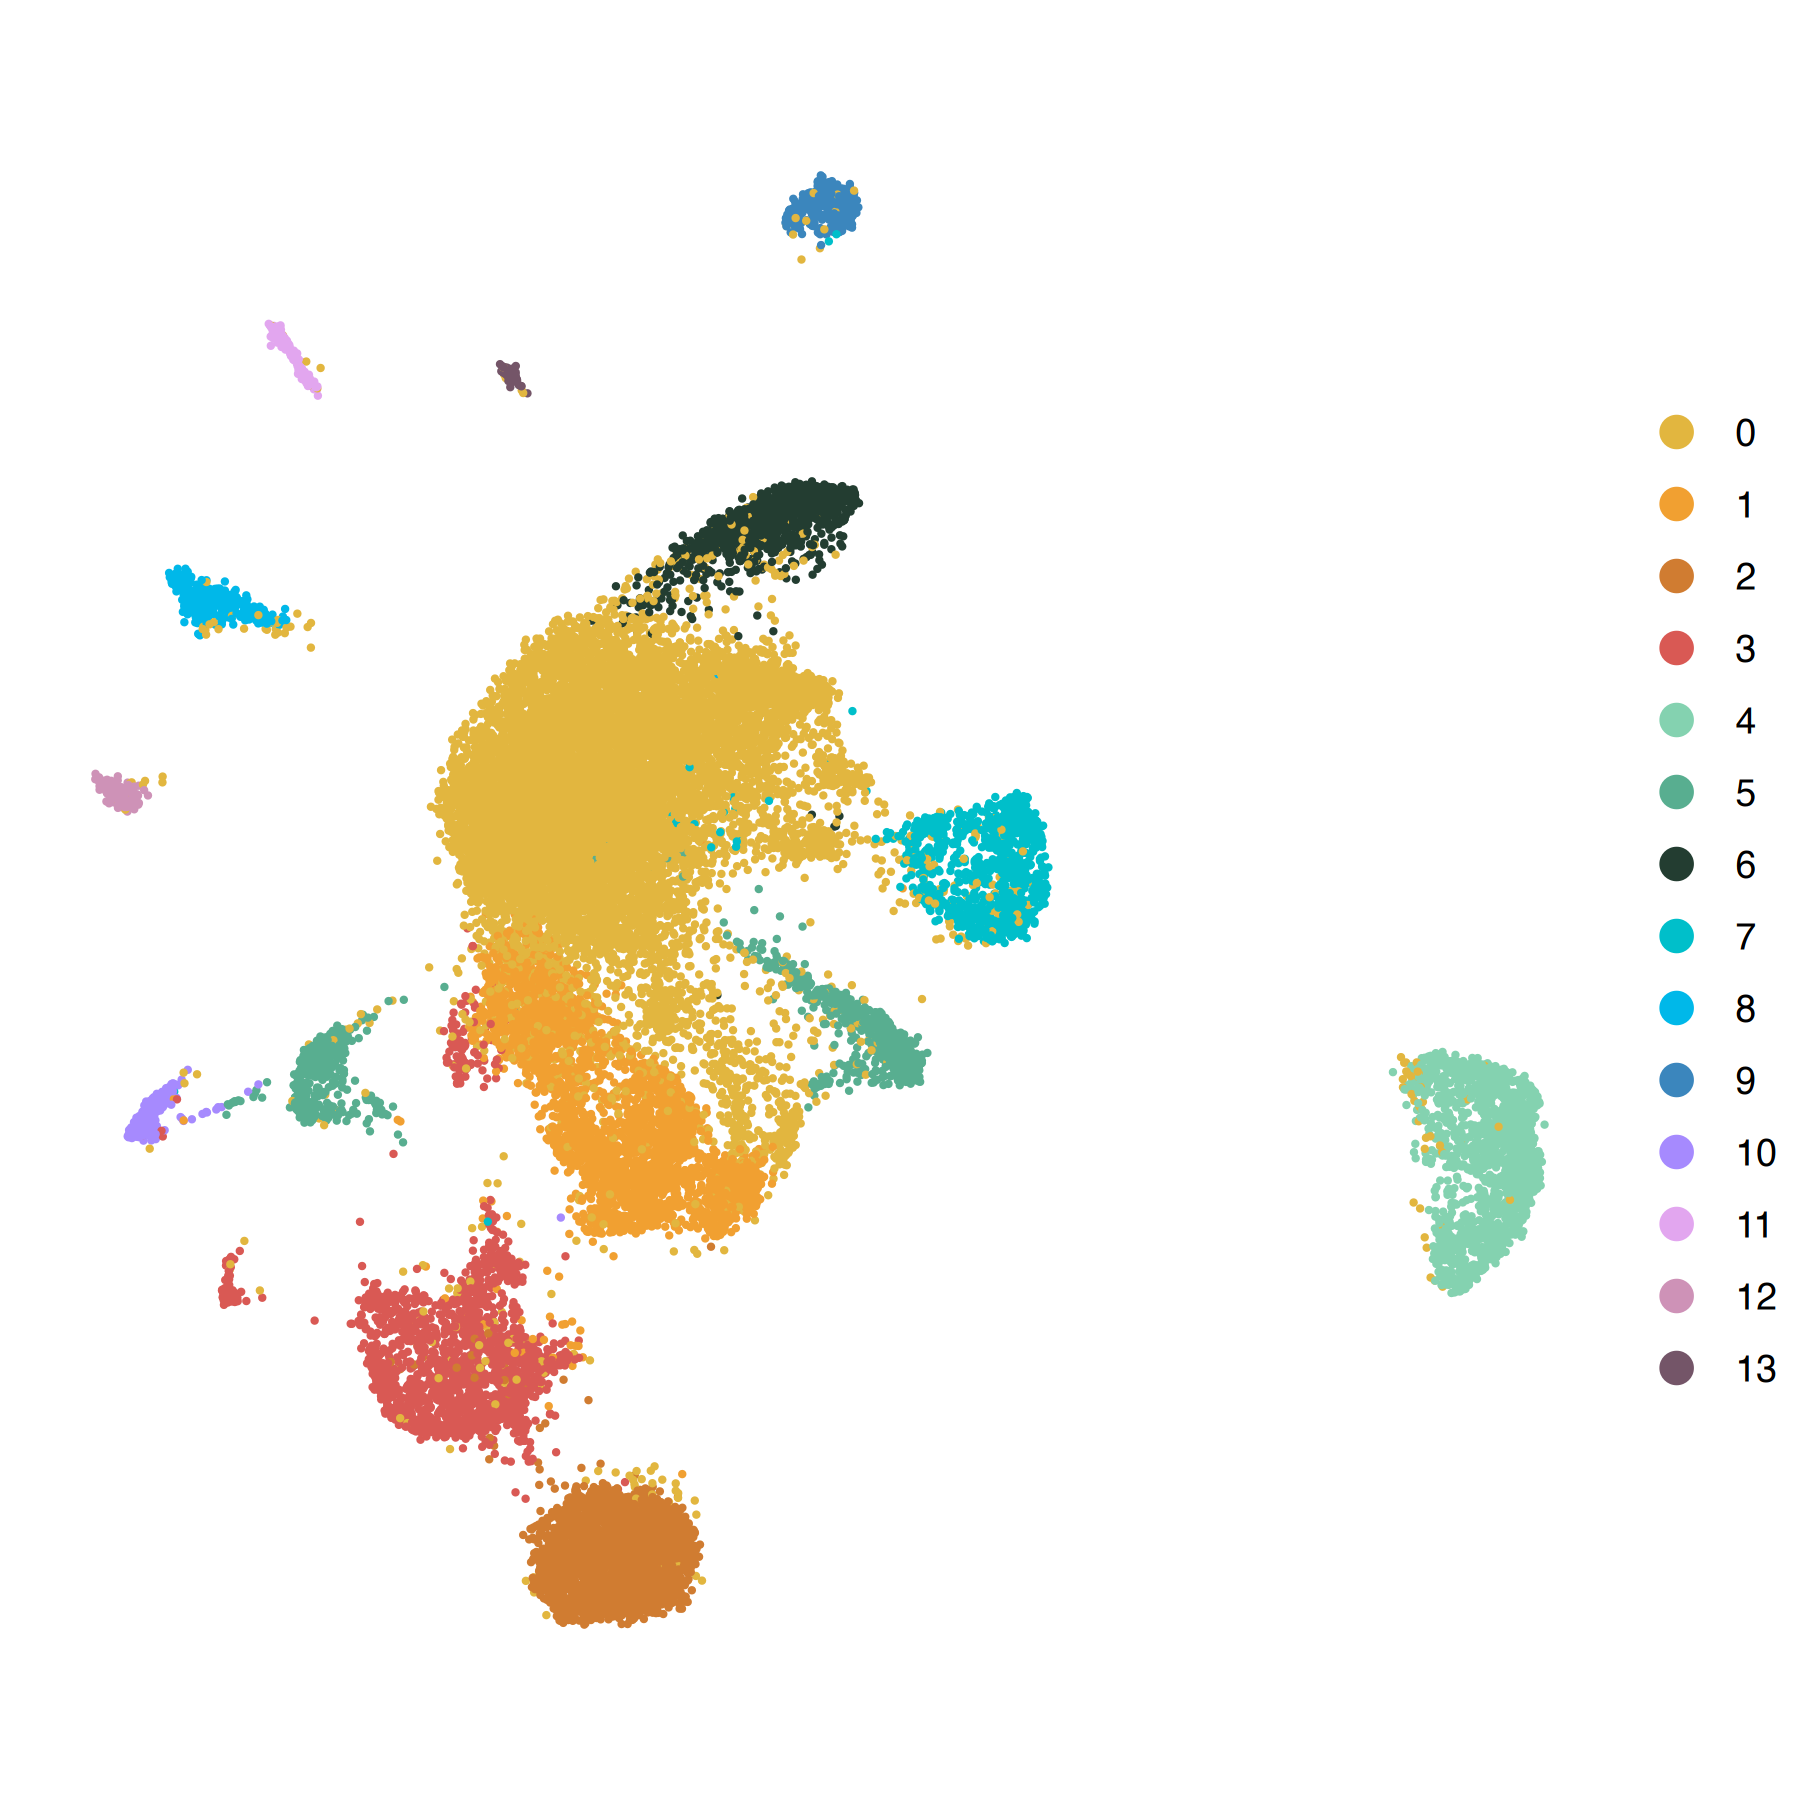

In [3]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)

image = DimPlot(mouse) + 
    scale_color_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + theme_void() + 
    theme(aspect.ratio = 1)

image_nolegend = DimPlot(mouse) + 
    scale_color_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + theme_void() + 
    theme(aspect.ratio = 1) + NoLegend()

legend = as_ggplot(ggpubr::get_legend(image))

ggsave(file="outputs/figures/figure3a_umap.png", plot=image_nolegend, width=5, height=5)
ggsave(file="outputs/figures/figure3a_umap_legend.svg", plot=legend, width=5, height=5)

image

We can also see that this object includes a t-SNE dimension reduction as well, which appears to correspond to the one originally shown in [Figure 2A of the original Wheeler et al manuscript](https://pmc.ncbi.nlm.nih.gov/articles/PMC8049843/figure/F2/):

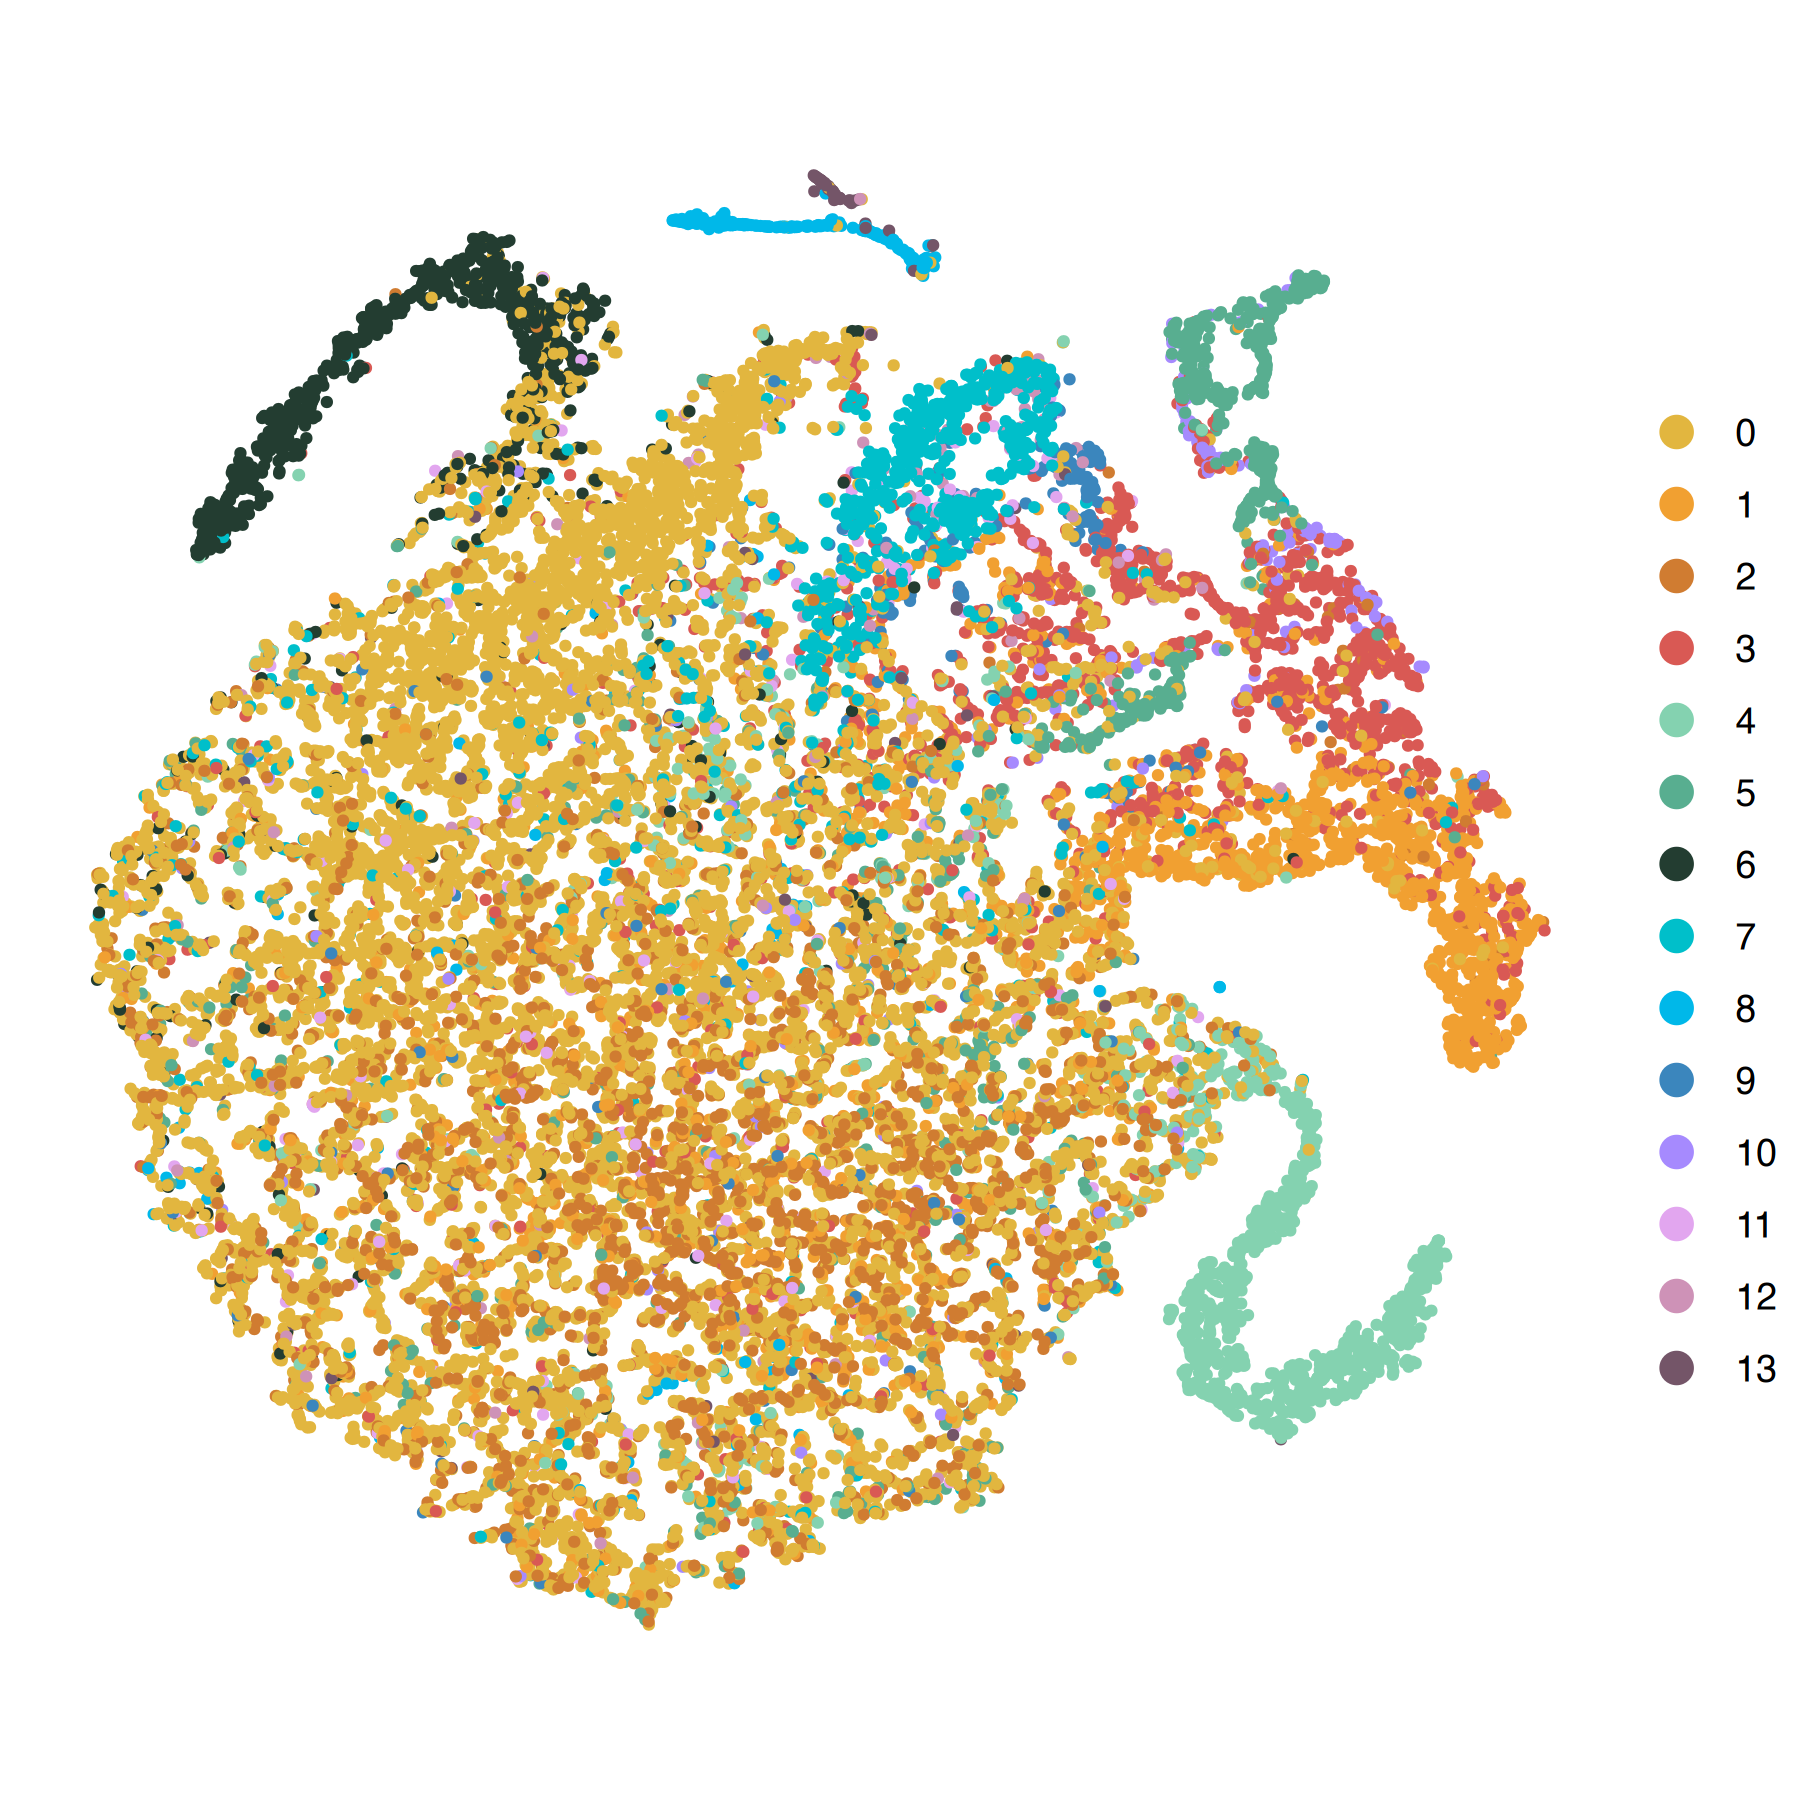

In [4]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)

image = DimPlot(mouse, reduction = "tsne", pt.size = 0.5) + 
    scale_color_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + theme_void() + 
    theme(aspect.ratio = 1)

image_nolegend = DimPlot(mouse, reduction = "tsne") + 
    scale_color_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + theme_void() + 
    theme(aspect.ratio = 1) + NoLegend()

legend = as_ggplot(ggpubr::get_legend(image))

ggsave(file="outputs/figures/figure3a_tsne.png", plot=image_nolegend, width=5, height=5)
ggsave(file="outputs/figures/figure3a_tsne_legend.svg", plot=legend, width=5, height=5)

image

Compared to the original presentation in the Wheeler paper, Lee et al seem to have re-clustered the dataset. The Wheeler paper described a special population of MAFG-driven astrocytes (Cluster 5 in the original paper) which appear to correspond to Lee et al's Cluster 1 as labeled in the t-SNE shown above.

Let's check what marker genes define each cluster. For this, we'll use the `wilcoxauc` function from the `presto` package to run a fast implementation of the Wilcoxon rank-sum test. Based on [recent work (Moses et al 2023, PMID: 37645732)](https://www.biorxiv.org/content/10.1101/2023.07.20.549945v2) comparing the formulas used to calculate log2-fold changes between Seurat, Scanpy, and other packages, we chose to use the formula from the Scanpy package instead of the one from Seurat.

In [5]:
# geometric mean with static pseudocount (Scanpy log2FC formula)
mean.fxn_geo <- function(x) {
    return(log(x = (expm1(rowMeans(x = x)) + 1e-9), base = 2))
}

# create an empty list for comparing FoldChange calculation results across all clusters
presto_results <- data.frame()

for(i in levels(Idents(mouse))){ # loop through all clusters
    
    print(paste0("Calculating markers for cluster ", i))
    
    data <- GetAssayData(object = mouse[['RNA']], layer = "data")
    
    # get cell names for groupings (from differential_expression.R line 1701-1749 [https://github.com/satijalab/seurat/blob/master/R/differential_expression.R#L1701])
    IdentsToCells <- function(
      object,
      ident.1,
      ident.2,
      cellnames.use
    ) {
      #
      if (is.null(x = ident.1)) {
        stop("Please provide ident.1")
      } 
      if (length(x = as.vector(x = ident.1)) > 1 &&
          any(as.character(x = ident.1) %in% cellnames.use)) {
        bad.cells <- cellnames.use[which(x = !as.character(x = ident.1) %in% cellnames.use)]
        if (length(x = bad.cells) > 0) {
          stop(paste0("The following cell names provided to ident.1 are not present in the object: ", paste(bad.cells, collapse = ", ")))
        }
      } else {
        ident.1 <- WhichCells(object = object, idents = ident.1)
      }
      # if NULL for ident.2, use all other cells
      if (length(x = as.vector(x = ident.2)) > 1 &&
          any(as.character(x = ident.2) %in% cellnames.use)) {
        bad.cells <- cellnames.use[which(!as.character(x = ident.2) %in% cellnames.use)]
        if (length(x = bad.cells) > 0) {
          stop(paste0("The following cell names provided to ident.2 are not present in the object: ", paste(bad.cells, collapse = ", ")))
        }
      } else {
        if (is.null(x = ident.2)) {
          ident.2 <- setdiff(x = cellnames.use, y = ident.1)
        } else {
          ident.2 <- WhichCells(object = object, idents = ident.2)
        }
      }
      return(list(cells.1 = ident.1, cells.2 = ident.2))
    }
    
    # extract cell lists using IdentsToCells function
    cells <- IdentsToCells(object = mouse, ident.1 = i, ident.2 = NULL, cellnames.use = colnames(mouse))
    cells.1 <- cells$cells.1
    cells.2 <- cells$cells.2

    # order data matrix by group
    data <- data[, c(cells.1, cells.2), drop = FALSE]

    # calculate Scanpy fold change
    data.1 <- mean.fxn_geo(data[, cells.1, drop = FALSE])
    data.2 <- mean.fxn_geo(data[, cells.2, drop = FALSE])
    fc_geo <- (data.1 - data.2)

    # get group labels
    group.info <- data.frame(row.names = c(cells.1, cells.2))
    group.info[cells.1, "group"] <- "Group1"
    group.info[cells.2, "group"] <- "Group2"
    group.info[, "group"] <- factor(x = group.info[, "group"])

    # run presto wilcoxon test
    res <- wilcoxauc(X = data, y = group.info[, "group"])
    res <- res[1:(nrow(x = res)/2),]
    res$cluster <- i
    res$log2FC = fc_geo

    res$padj <- NULL
    res$logFC <- NULL
    res$group <- NULL
    
    
    res$p_val_adj = p.adjust(
      p =res$pval,
      method = "bonferroni",
      n = nrow(data)
    )
    
    presto_results <- rbind(presto_results, res)

}
# replace zero p-values with more accurate minimum value representable
presto_results = presto_results %>% mutate(p_val_adj = ifelse(p_val_adj == 0, .Machine$double.xmin, p_val_adj))

(presto_results %>% filter(cluster == '3') %>% arrange(p_val_adj, desc(log2FC)))[1:20,]

[1] "Calculating markers for cluster 0"
[1] "Calculating markers for cluster 1"
[1] "Calculating markers for cluster 2"
[1] "Calculating markers for cluster 3"
[1] "Calculating markers for cluster 4"
[1] "Calculating markers for cluster 5"
[1] "Calculating markers for cluster 6"
[1] "Calculating markers for cluster 7"
[1] "Calculating markers for cluster 8"
[1] "Calculating markers for cluster 9"
[1] "Calculating markers for cluster 10"
[1] "Calculating markers for cluster 11"
[1] "Calculating markers for cluster 12"
[1] "Calculating markers for cluster 13"


feature avgExpr   statistic auc       pval pct_in    pct_out     cluster
1  Sirpb1c 0.3541667 25196391  0.5811830 0    16.347178  0.10829543 3      
2  F13a1   0.2860919 24372386  0.5621764 0    12.513312  0.07364089 3      
3  F10     0.3893235 25318711  0.5840044 0    16.932907  0.12995452 3      
4  Gm21188 0.2221033 23958206  0.5526228 0    10.596379  0.06930908 3      
5  Lyz2    4.4029299 39077576  0.9013680 0    84.984026 13.48927875 3      
6  Klra2   0.1708419 23360168  0.5388284 0     7.827476  0.06064544 3      
7  Gm36161 0.2067543 23838516  0.5498621 0    10.063898  0.09096816 3      
8  Clec12a 0.4633743 26070514  0.6013456 0    20.500532  0.22092268 3      
9  Hp      0.4803543 25891453  0.5972153 0    19.701810  0.25990903 3      
10 Clec4e  0.5126128 25867108  0.5966538 0    19.595314  0.26424085 3      
11 Tgfbi   1.2357885 31446086  0.7253392 0    46.006390  0.89235434 3      
12 Ms4a7   0.9347878 29137642  0.6720923 0    35.037274  0.60212259 3      
13 Arg1    0.7038419 26418098  0.6093630 0    22.257721  0.39419536 3      
14 Napsa   0.2181152 23846434  0.5500447 0    10.117146  0.10396361 3      
15 Clec4n  0.6072250 26835525  0.6189914 0    24.174654  0.36820446 3      
16 Bst1    0.1633936 23376724  0.5392103 0     7.933972  0.09096816 3      
17 Dpep2   0.1940006 23629140  0.5450326 0     9.105431  0.09529998 3      
18 Gda     0.2588197 24240099  0.5591250 0    11.980831  0.15161360 3      
19 H2-Ab1  3.9030859 38631023  0.8910678 0    84.664537 13.40264241 3      
20 Lgals3  1.8412851 33967123  0.7834897 0    58.785942  2.41282218 3      
   log2FC   p_val_adj    
1  7.352586 2.225074e-308
2  7.202389 2.225074e-308
3  7.197942 2.225074e-308
4  7.128248 2.225074e-308
5  7.046146 2.225074e-308
6  6.956240 2.225074e-308
7  6.770940 2.225074e-308
8  6.703008 2.225074e-308
9  6.586094 2.225074e-308
10 6.582607 2.225074e-308
11 6.561472 2.225074e-308
12 6.511665 2.225074e-308
13 6.442881 2.225074e-308
14 6.414518 2.225074e-308
15 6.388514 2.225074e-308
16 6.373073 2.225074e-308
17 6.287769 2.225074e-308
18 6.282906 2.225074e-308
19 6.245332 2.225074e-308
20 6.243647 2.225074e-308

Save the differential expression test results to a CSV file:

In [6]:
write.table(presto_results %>% arrange(cluster, p_val_adj, desc(log2FC)), 
            'outputs/mouse_clusters_de_test_results.csv', sep = ',', 
            quote = FALSE, row.names = FALSE, col.names = TRUE)

cluster3_sig_results <- presto_results %>% filter(cluster == '3') %>% filter(abs(log2FC) > 1) %>% 
    filter(p_val_adj < 0.05) %>% arrange(p_val_adj, desc(log2FC))
write.table(cluster3_sig_results, 'outputs/mouse_cluster3_wilcoxon_test_results_DEGs.csv', sep = ',', 
            quote = FALSE, row.names = FALSE, col.names = TRUE)

Next, let's create a volcano plot of the differential expression data from Cluster 3, the cluster labeled as epigenetic memory astrocytes by Lee et al.

Warning message:
“Removed 30262 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


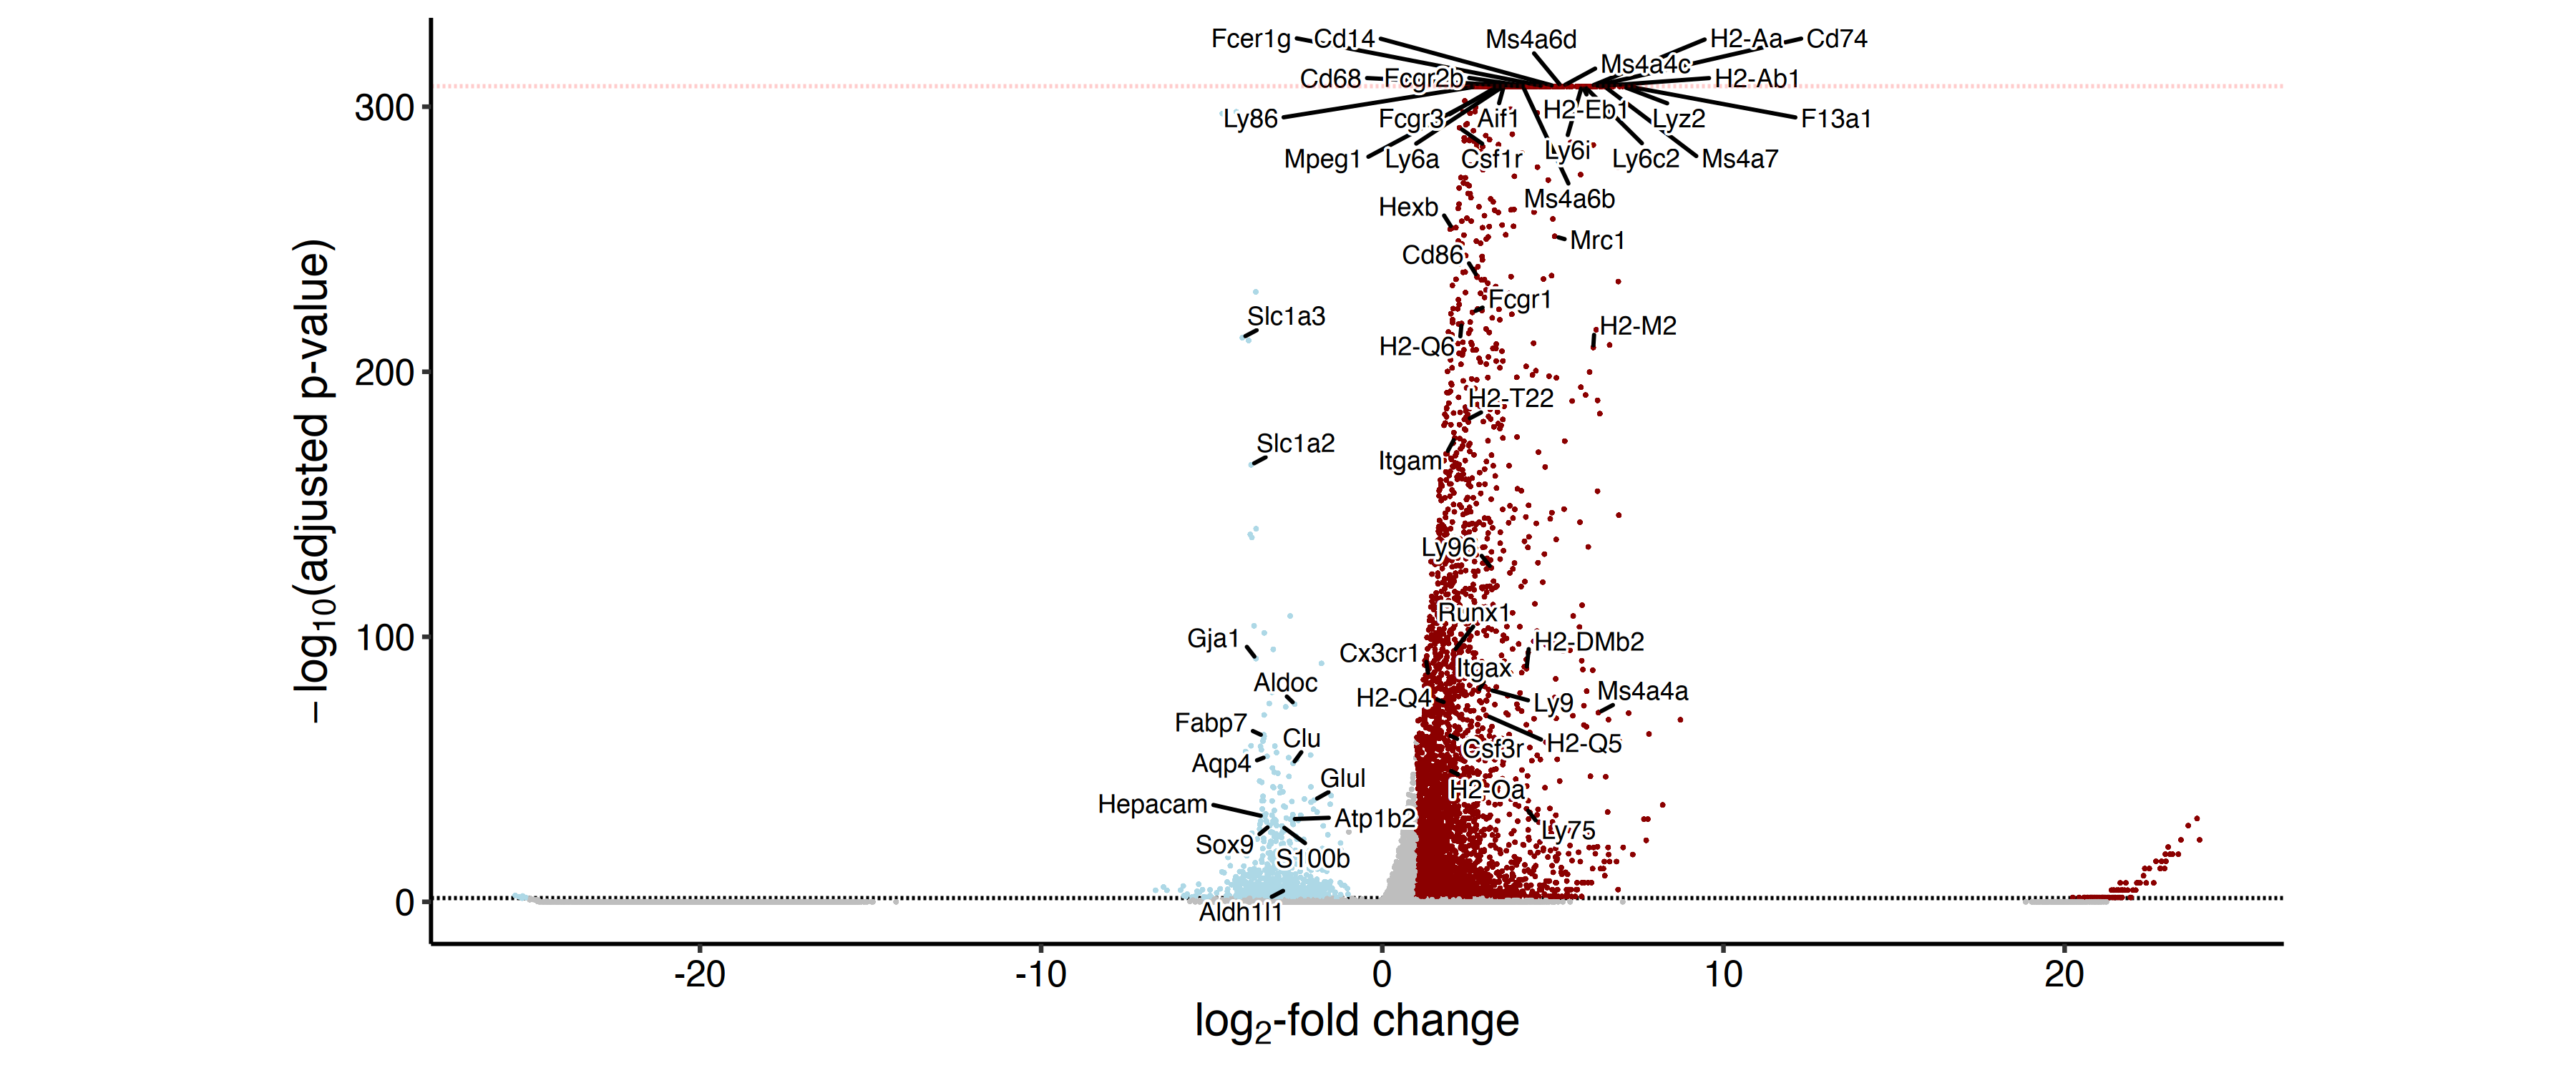

In [7]:
options(repr.plot.width=12, repr.plot.height=5, repr.plot.res = 300)

highlight_genes <- c('Cd14', 'Aif1', 'Csf1r', 'F13a1', 'F13a1', 'Mpeg1', 'Ms4a4c', 'Ms4a6b', 'Ms4a6d', 'Ms4a7', 'Ms4a4a',
                     'Ly6a', 'Ly6c2', 'Ly6i', 'Ly86', 'Ly96', 'Lyz2', 'Mrc1','Ly9','Ly75',
                    'Fcer1g', 'Fcgr2b', 'Fcgr3', 'Fcgr1',
                     'Cx3cr1', 'Cd86', 'Itgam', 'Cd68',
                     'Cd74', 'H2-Ab1', 'H2-Aa', 'H2-Eb1', 'Hexb', 'H2-Q6', 'H2-M2', 'H2-T22','Runx1','H2-DMb2','Itgax','H2-Q4','H2-Q5',"Csf3r",'H2-Oa',
                    'Aqp4', 'Slc1a3', 'Slc1a2', 'Clu', 'Aldoc', 'Atp1b2', 'Gja1', 'Glul', 'Hepacam', 'S100b', 'Fabp7', 'Sox9', 'Aldh1l1')
ggplot(data = presto_results %>% filter(cluster == "3") %>% mutate(label = ifelse(feature %in% highlight_genes, feature, NA)) %>% 
                                                                         mutate(significance = ifelse((p_val_adj < 0.05) & (log2FC > 1), "Up", 
                                                                                              ifelse((p_val_adj < 0.05) & (log2FC < -1), "Down",
                                                                                                    "NS"))), 
       aes(x = log2FC, y = -log10(p_val_adj), label = label, color = significance)) +
  geom_hline(yintercept = -log10(0.05), col = "black", linetype = 'dashed') + 
  rasterize(geom_point(size = 0.1), dpi = 1200) + 
    labs(x = expression(paste(log[2],"-fold change")), y = expression(paste(-log[10], "(adjusted p-value)"))) + 
    scale_color_manual(values = c('lightblue', 'gray', 'darkred'), guide = NULL) + 
     geom_text_repel(max.overlaps = Inf, segment.color = "black",
                    nudge_y = 2, min.segment.length = 0, 
                     fontface = 'italic',
                    bg.color = "white",
                     color = "black",
                     size = 3,
                    bg.r = .15) + 
    ylim(0, -log10(.Machine$double.xmin)+10) + 
    geom_hline(yintercept = -log10(.Machine$double.xmin), col = "red", linetype = 'dashed', alpha = 0.2) + 
    theme_pubr() + 
  theme(
              axis.title.y = element_text(size = 15),
              axis.title.x = element_text(size=15),
      aspect.ratio = 0.5
            )

We'll clip the x-axis at ±10 log2-fold change to make it easier to see the majority of data points. More extreme fold changes typically indicate genes with very low expression in one group and usually have uncertain fold change estimates.

Warning message:
“Removed 12198 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 30262 rows containing missing values or values outside the scale range (`geom_text_repel()`).”
Warning message:
“Removed 12198 rows containing missing values or values outside the scale range (`geom_point()`).”
Warning message:
“Removed 30262 rows containing missing values or values outside the scale range (`geom_text_repel()`).”


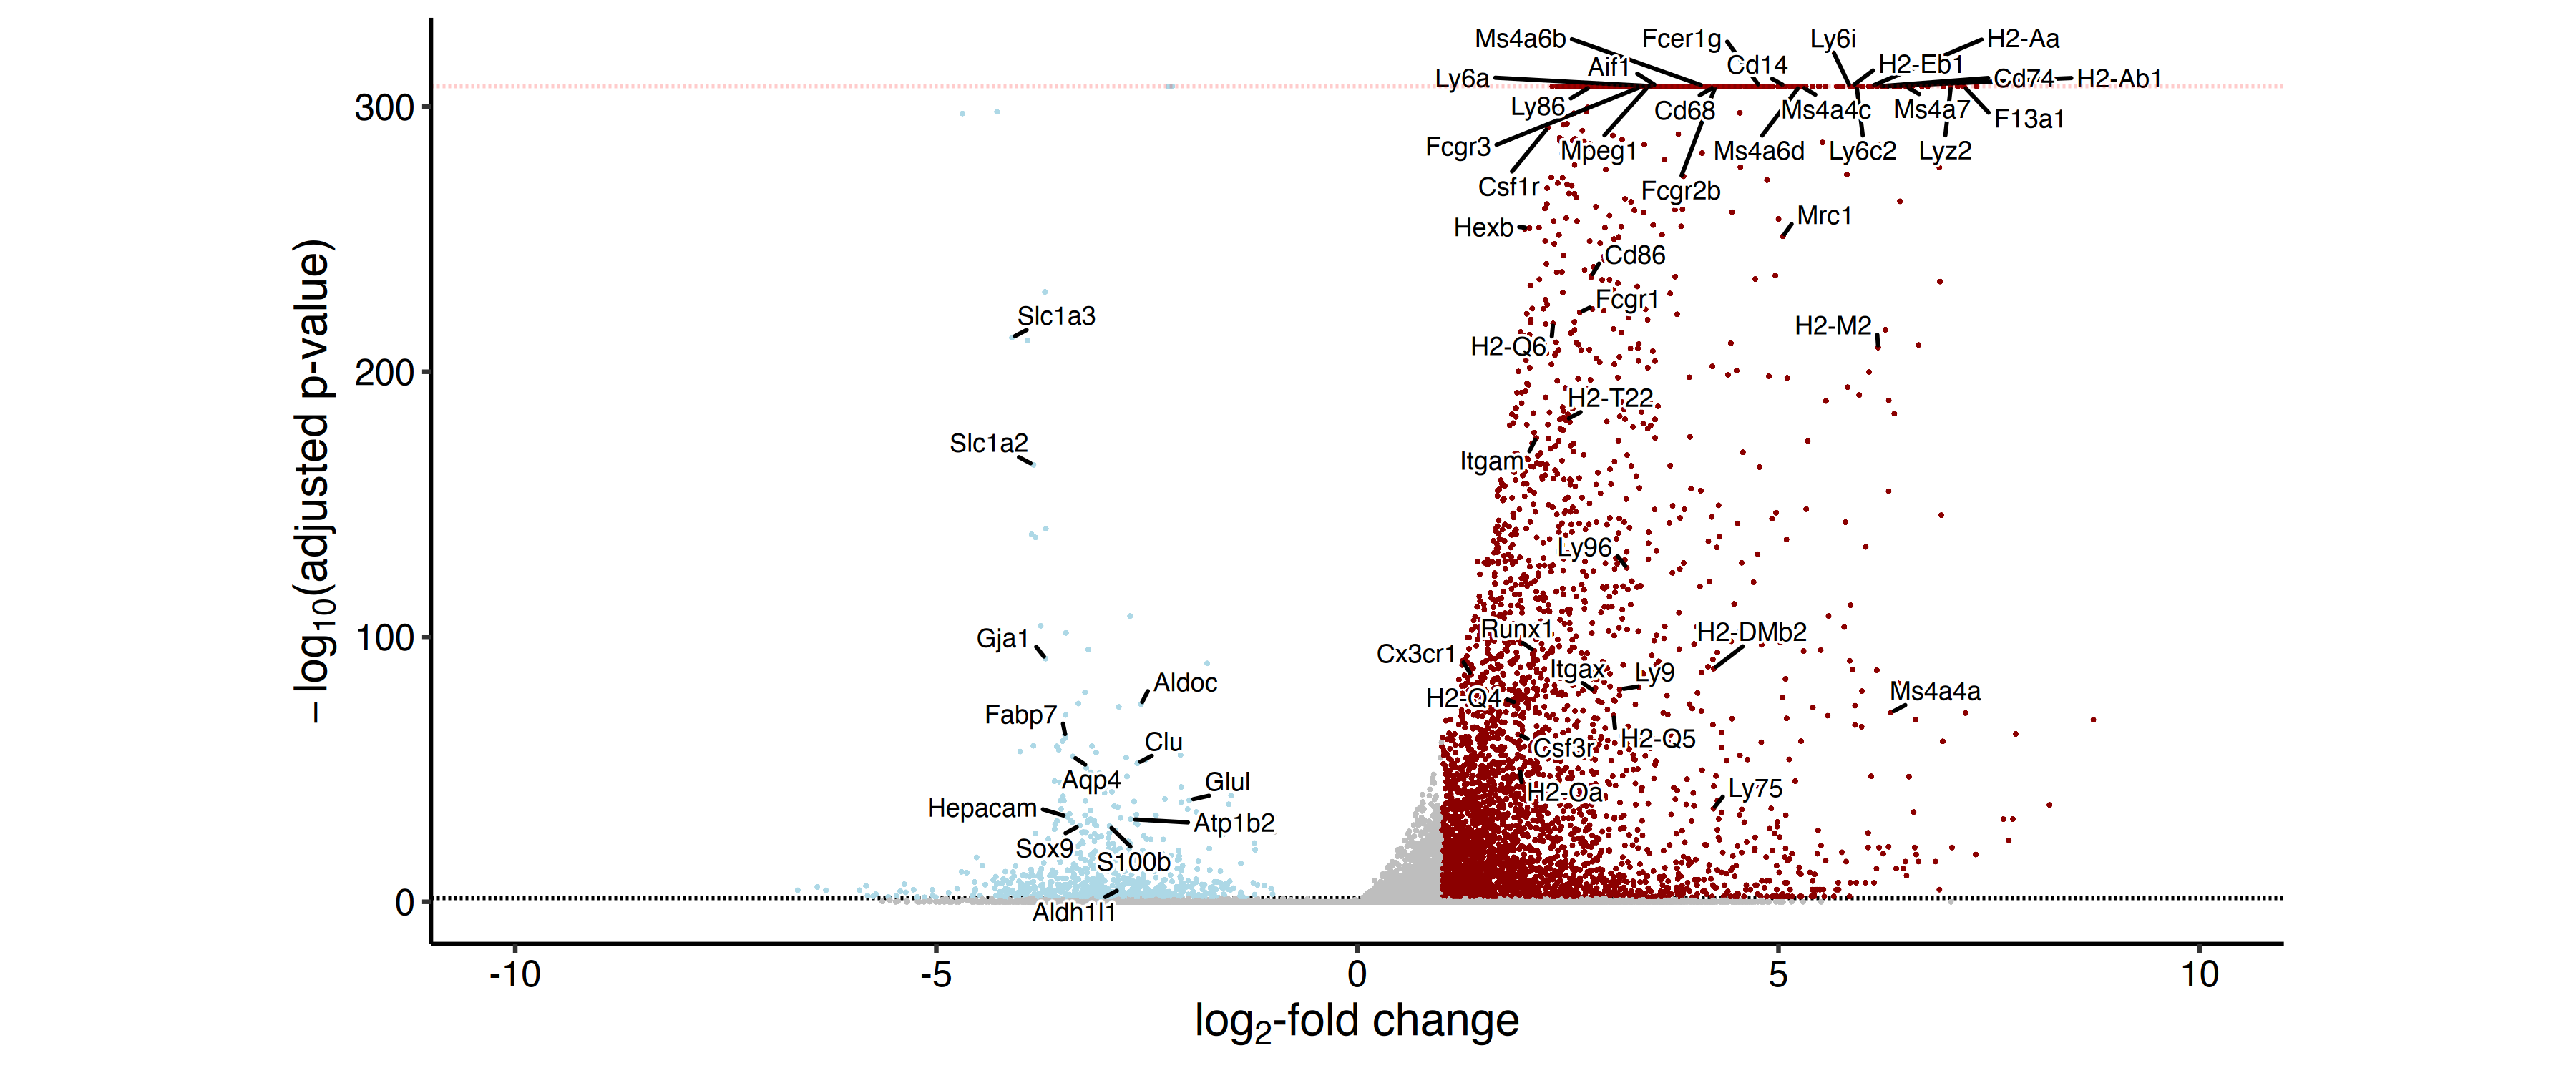

In [8]:
options(repr.plot.width=12, repr.plot.height=5, repr.plot.res = 300)

highlight_genes <- c('Cd14', 'Aif1', 'Csf1r', 'F13a1', 'F13a1', 'Mpeg1', 'Ms4a4c', 'Ms4a6b', 'Ms4a6d', 'Ms4a7', 'Ms4a4a',
                     'Ly6a', 'Ly6c2', 'Ly6i', 'Ly86', 'Ly96', 'Lyz2', 'Mrc1','Ly9','Ly75',
                    'Fcer1g', 'Fcgr2b', 'Fcgr3', 'Fcgr1',
                     'Cx3cr1', 'Cd86', 'Itgam', 'Cd68',
                     'Cd74', 'H2-Ab1', 'H2-Aa', 'H2-Eb1', 'Hexb', 'H2-Q6', 'H2-M2', 'H2-T22','Runx1','H2-DMb2','Itgax','H2-Q4','H2-Q5',"Csf3r",'H2-Oa',
                    'Aqp4', 'Slc1a3', 'Slc1a2', 'Clu', 'Aldoc', 'Atp1b2', 'Gja1', 'Glul', 'Hepacam', 'S100b', 'Fabp7', 'Sox9', 'Aldh1l1')
image = ggplot(data = presto_results %>% filter(cluster == "3") %>% mutate(label = ifelse(feature %in% highlight_genes, feature, NA)) %>% 
                                                                         mutate(significance = ifelse((p_val_adj < 0.05) & (log2FC > 1), "Up", 
                                                                                              ifelse((p_val_adj < 0.05) & (log2FC < -1), "Down",
                                                                                                    "NS"))), 
       aes(x = log2FC, y = -log10(p_val_adj), label = label, color = significance)) +
  geom_hline(yintercept = -log10(0.05), col = "black", linetype = 'dashed') + 
  rasterize(geom_point(size = 0.1), dpi = 1200) + 
    labs(x = expression(paste(log[2],"-fold change")), y = expression(paste(-log[10], "(adjusted p-value)"))) + 
    scale_color_manual(values = c('lightblue', 'gray', 'darkred'), guide = NULL) + 
    scale_x_continuous(limits = c(-10, 10)) + ### added in limits here clipping the x axis at ±10 log2-fold change for easier visualization; this excludes a few genes from the plot with a very high fold change but higher p-value
     geom_text_repel(max.overlaps = Inf, segment.color = "black",
                    nudge_y = 2, min.segment.length = 0, 
                     fontface = 'italic',
                    bg.color = "white",
                     color = "black",
                     size = 3,
                    bg.r = .15) + 
    ylim(0, -log10(.Machine$double.xmin)+10) + 
    geom_hline(yintercept = -log10(.Machine$double.xmin), col = "red", linetype = 'dashed', alpha = 0.2) + 
    theme_pubr() + 
  theme(
              axis.title.y = element_text(size = 15),
              axis.title.x = element_text(size=15),
      aspect.ratio = 0.5
            )

ggsave(file="outputs/figures/figure3b.svg", plot=image, width=12, height=5)

image

Cluster 3 appears to be marked by increased expression of many macrophage genes, and lower expression of typical astrocyte marker genes. Let's examine expression overlaid on the UMAP embedding.

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


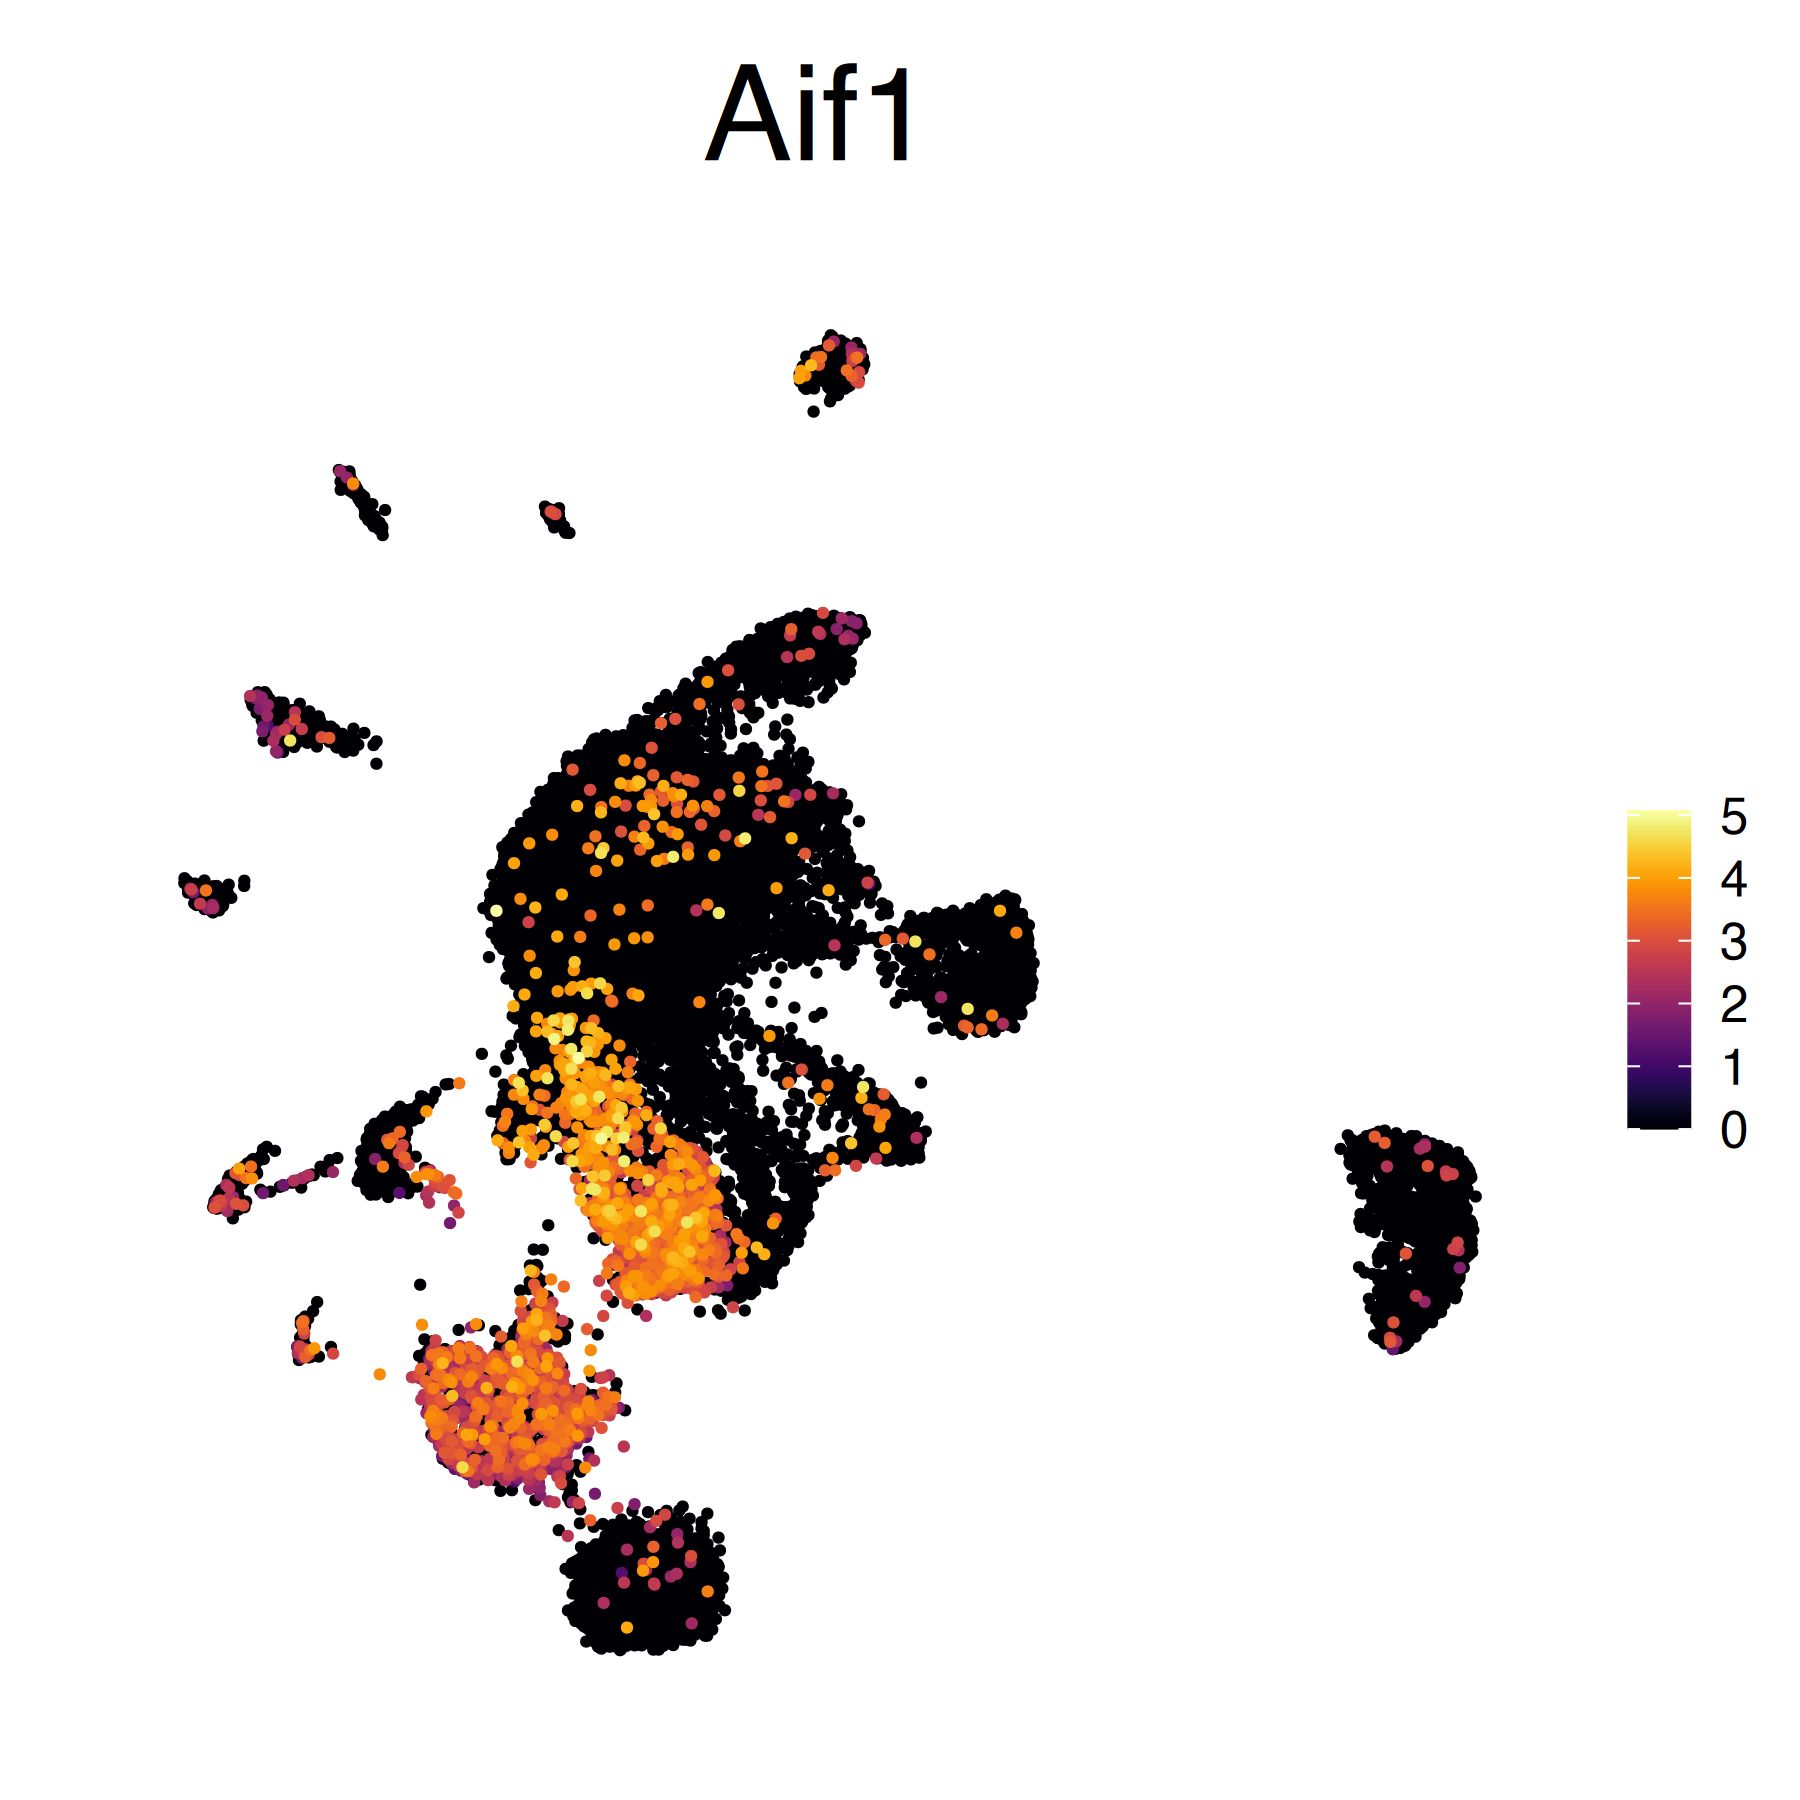

In [9]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)
FeaturePlot(mouse, feature = "Aif1", order = TRUE, pt.size = 0.5) +
    scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.text = element_blank(), axis.line = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank(),
            plot.title=element_text(size = 32, face = "bold.italic"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


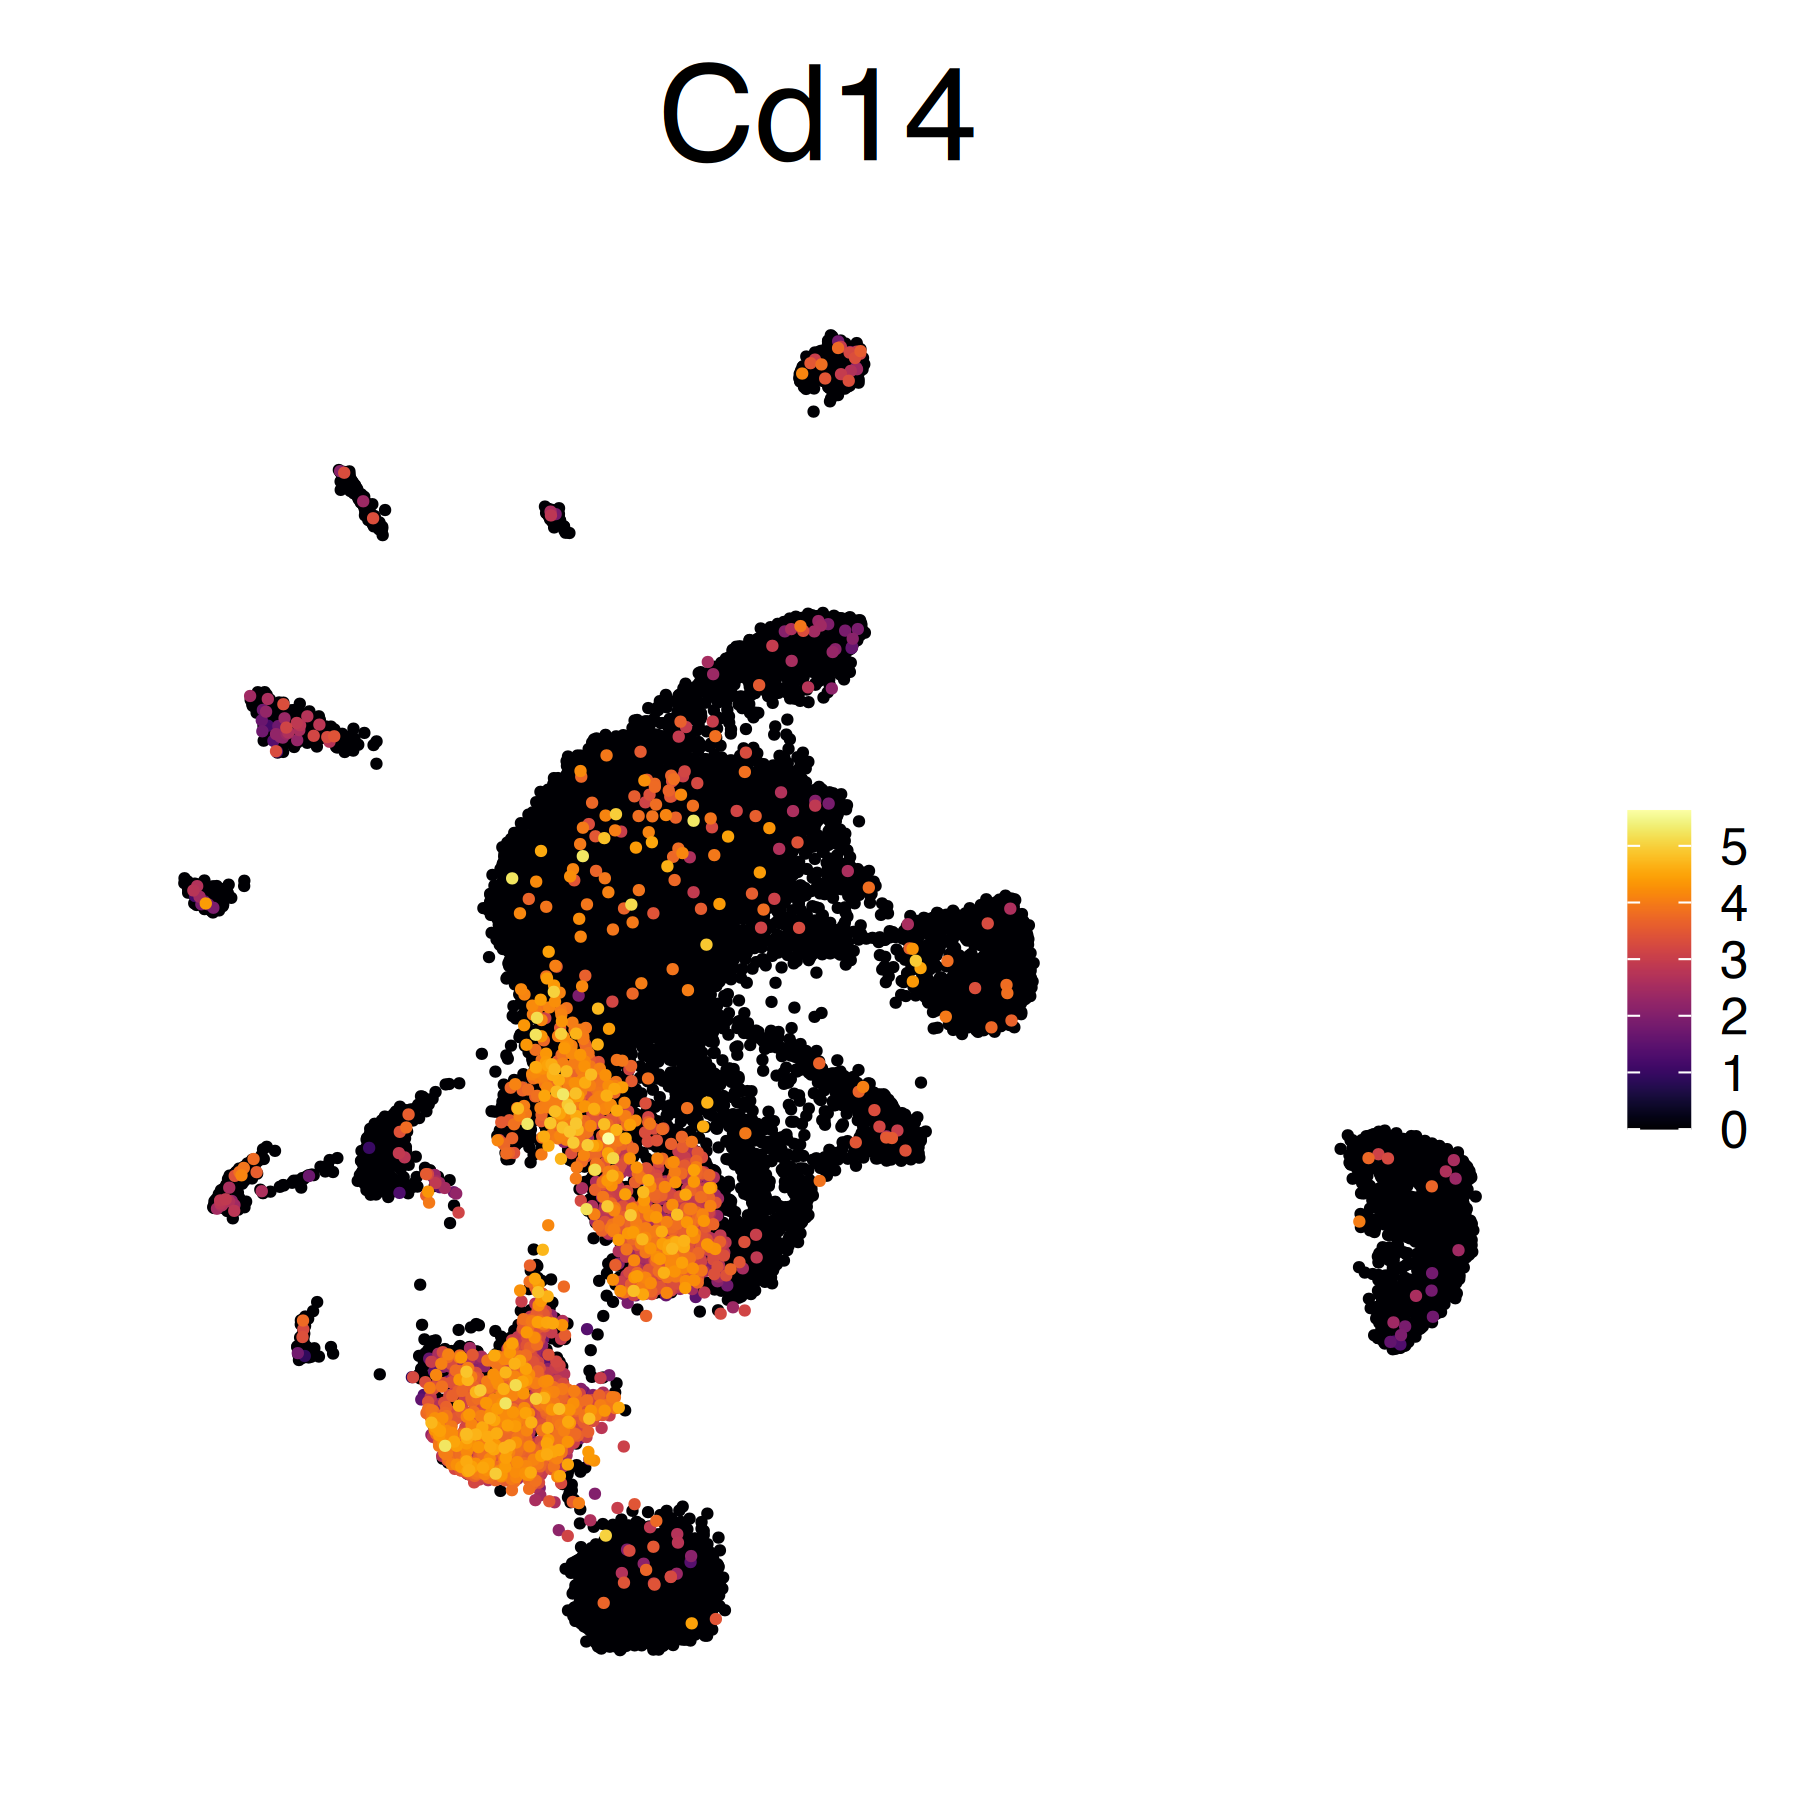

In [10]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)
FeaturePlot(mouse, feature = "Cd14", order = TRUE, pt.size = 0.5) +
    scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.text = element_blank(), axis.line = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank(),
            plot.title=element_text(size = 32, face = "bold.italic"))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


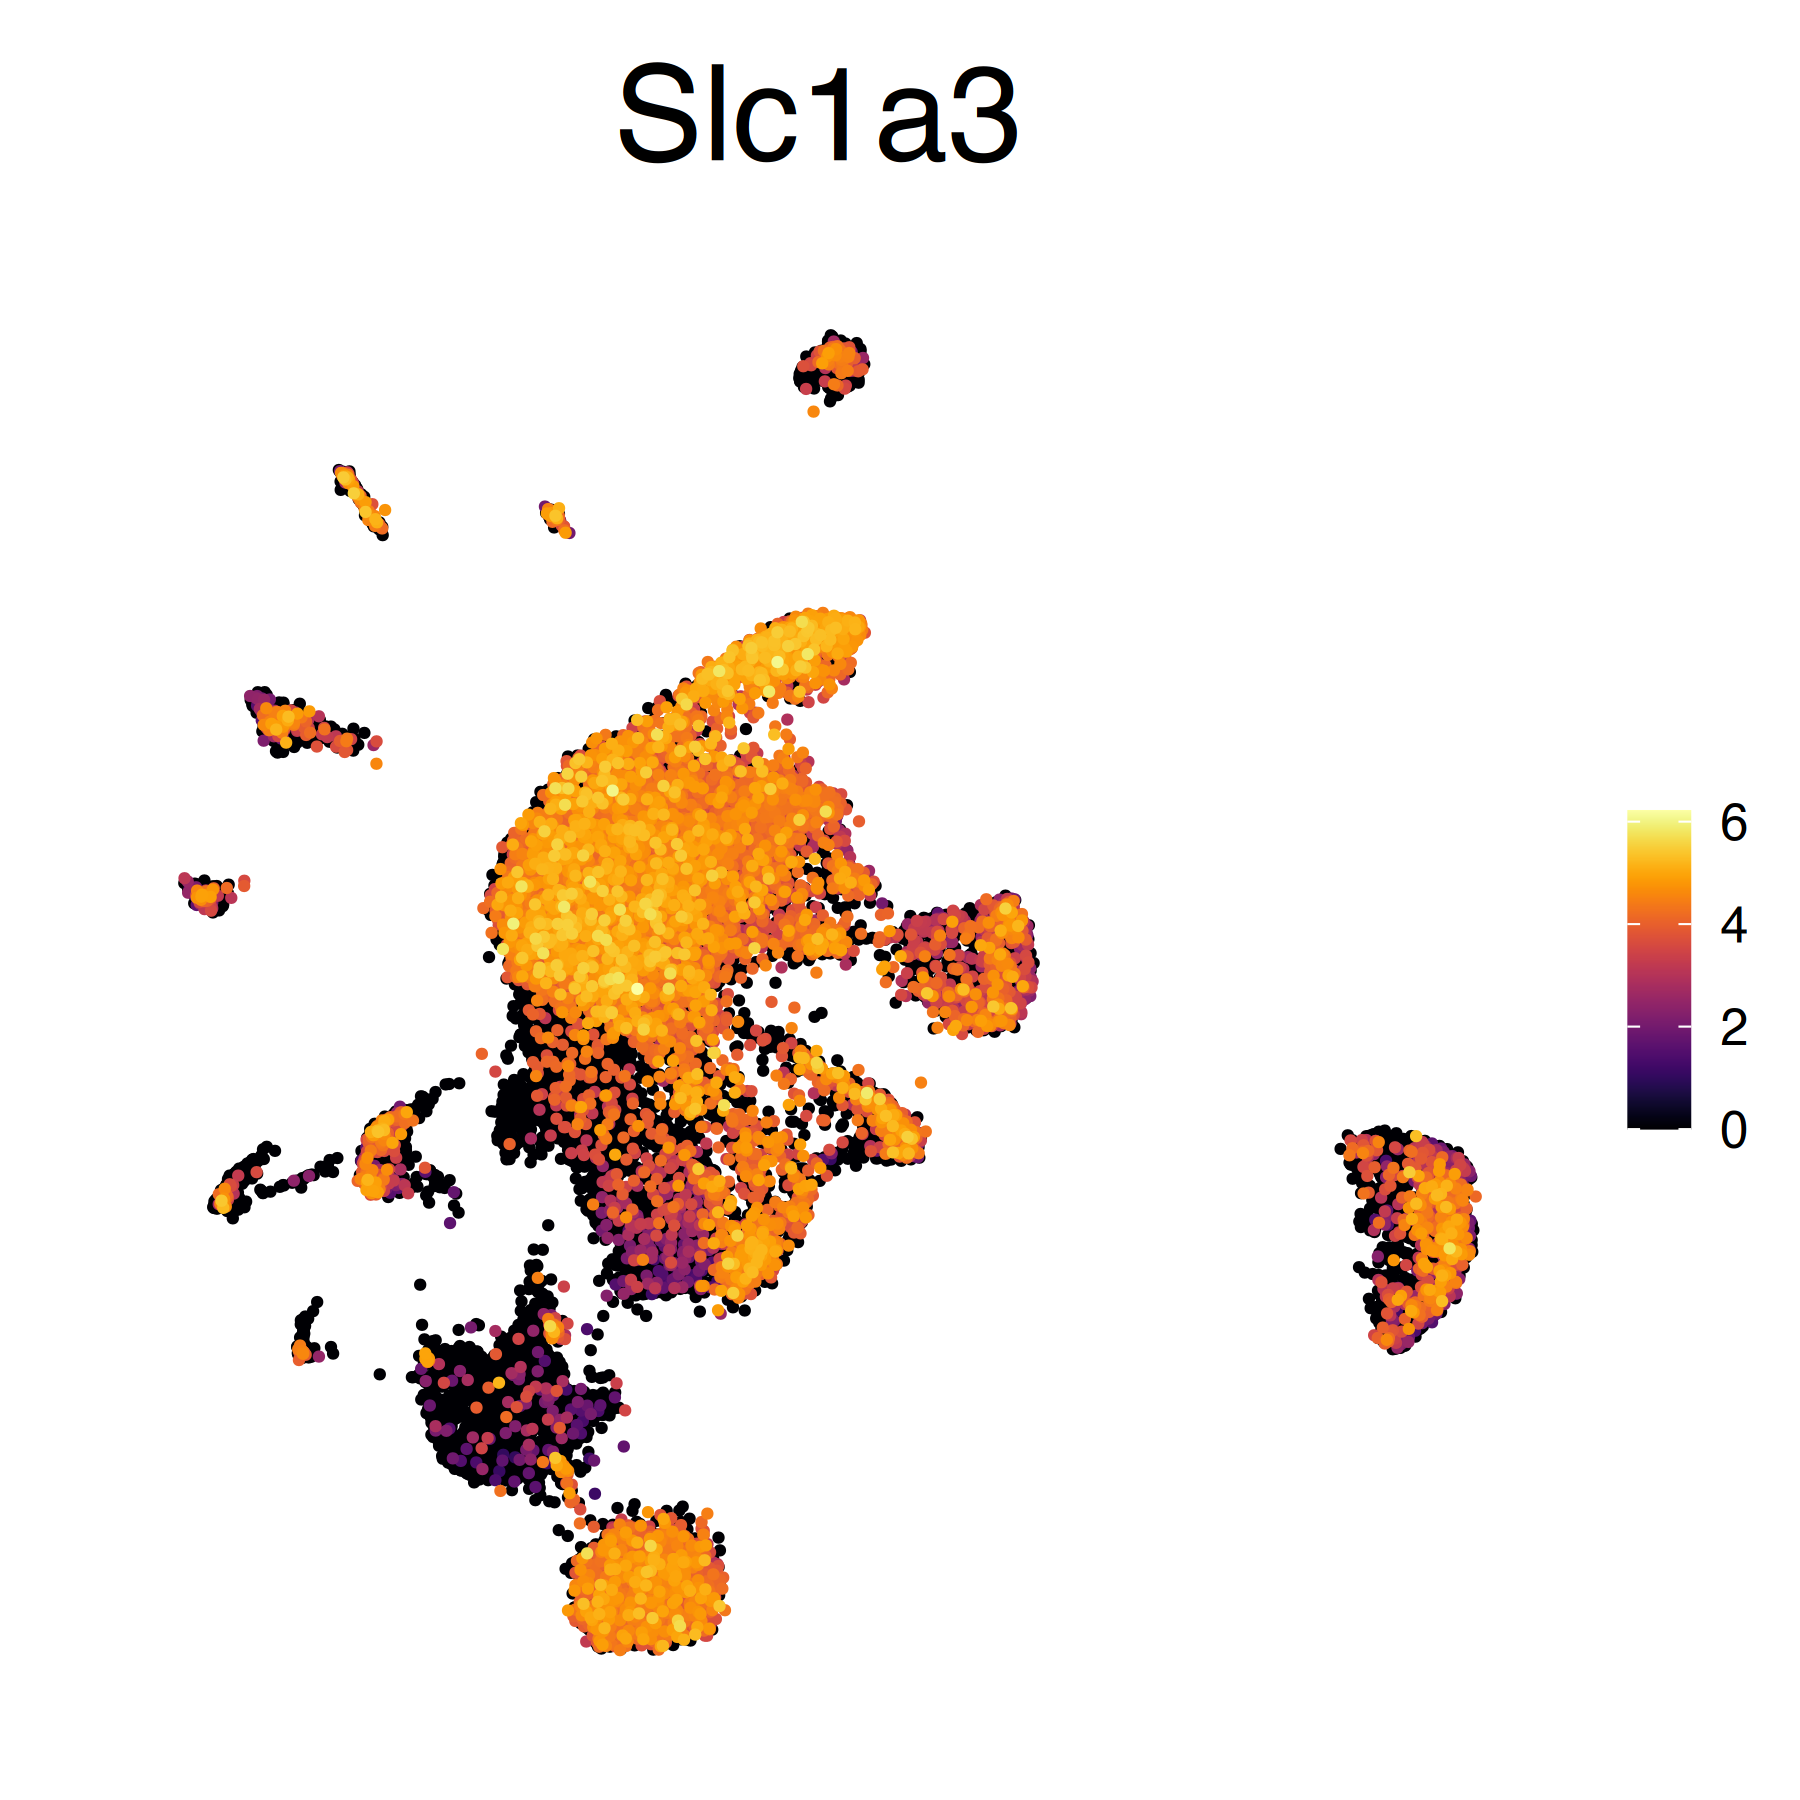

In [11]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)
FeaturePlot(mouse, feature = "Slc1a3", order = TRUE, pt.size = 0.5) +
    scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.text = element_blank(), axis.line = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank(),
            plot.title=element_text(size = 32, face = "bold.italic"))

We can see that Cluster 3 (as well as Cluster 1) are marked by increased expression of macrophage markers *Aif1* (IBA1) and Cd14. These clusters also exhibit lower expression of astrocyte marker genes like *Slc1a3* (GLAST).

Sometimes UMAP embeddings can be hard to interpret because of over-plotting, whereby a few cells with expression make it hard to see whether the majority of the cluster expresses the gene. Here we'll visualize expression of these same genes with a gene weighted density estimate using the `Nebulosa` package,.

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


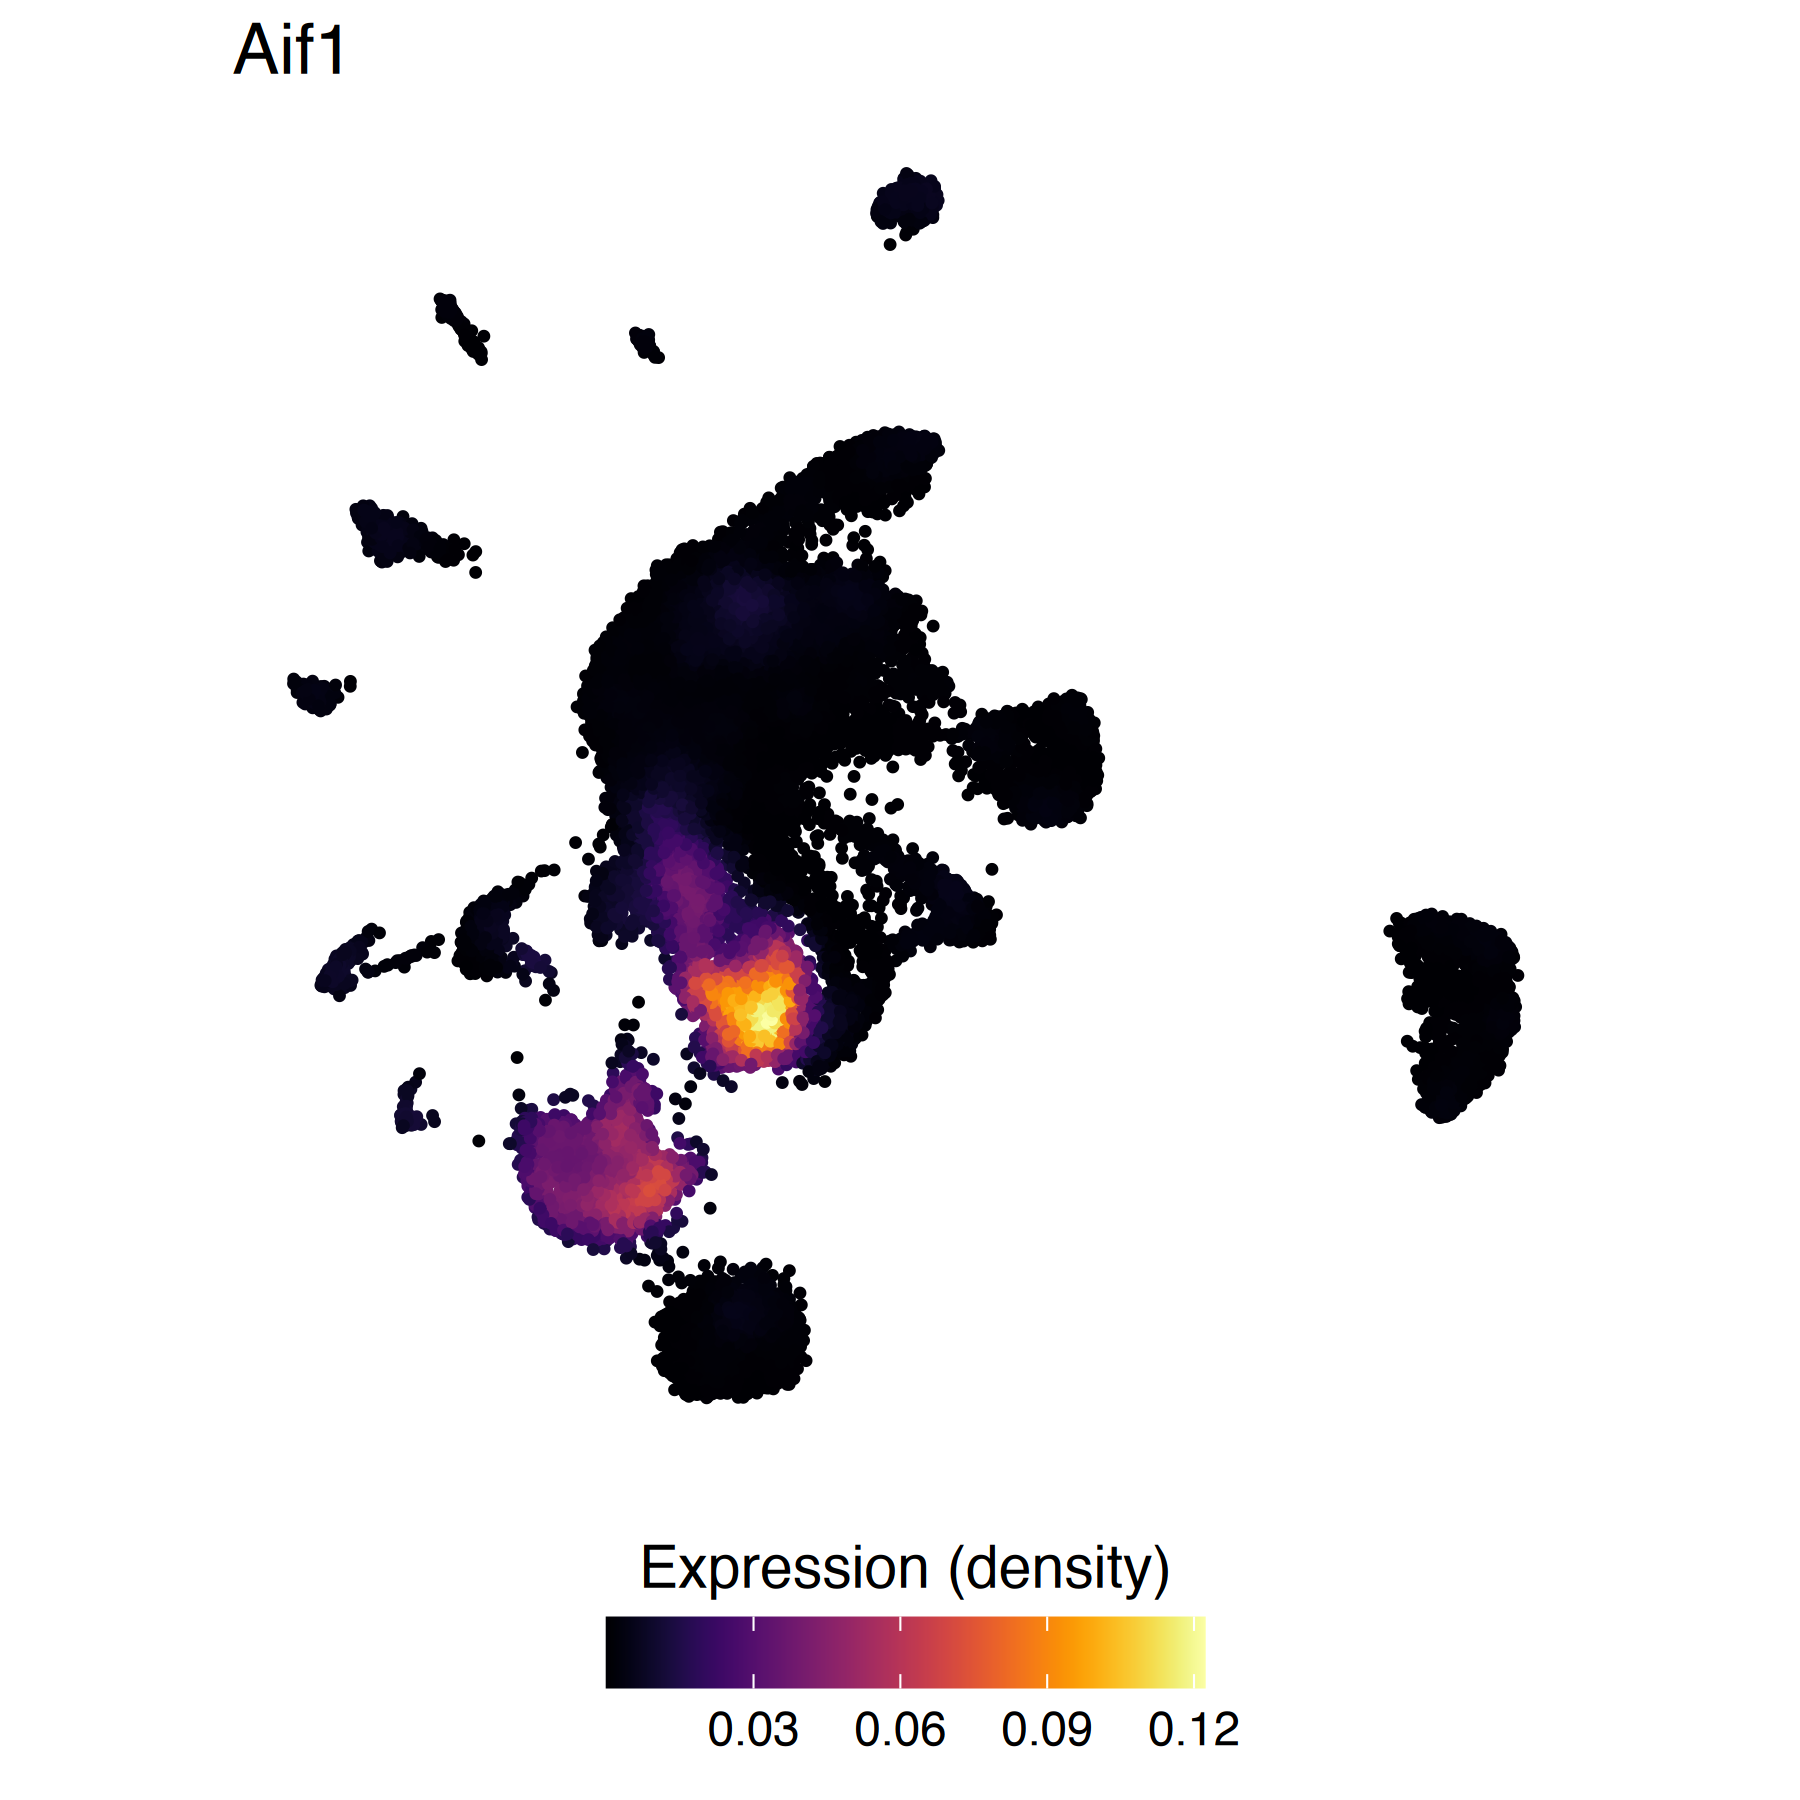

In [12]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)
image <- plot_density(mouse, "Aif1", reduction = "umap", slot = "data") + 
    scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), legend.position = 'bottom',
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank())  + labs(title = "Aif1", color = "Expression (density)") + 
    guides(color = guide_colourbar(title.position = "top", title.hjust=0.5, direction = 'horizontal', barwidth = 10))

image_nolegend <- plot_density(mouse, "Aif1", reduction = "umap", slot = "data") + 
    scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank()) + labs(title = "") + NoLegend()


legend = as_ggplot(ggpubr::get_legend(image))

ggsave(file="outputs/figures/figure3a_aif1.png", plot=image_nolegend, width=5, height=5)
ggsave(file="outputs/figures/figure3a_aif1_legend.svg", plot=legend, width=5, height=5)

image

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


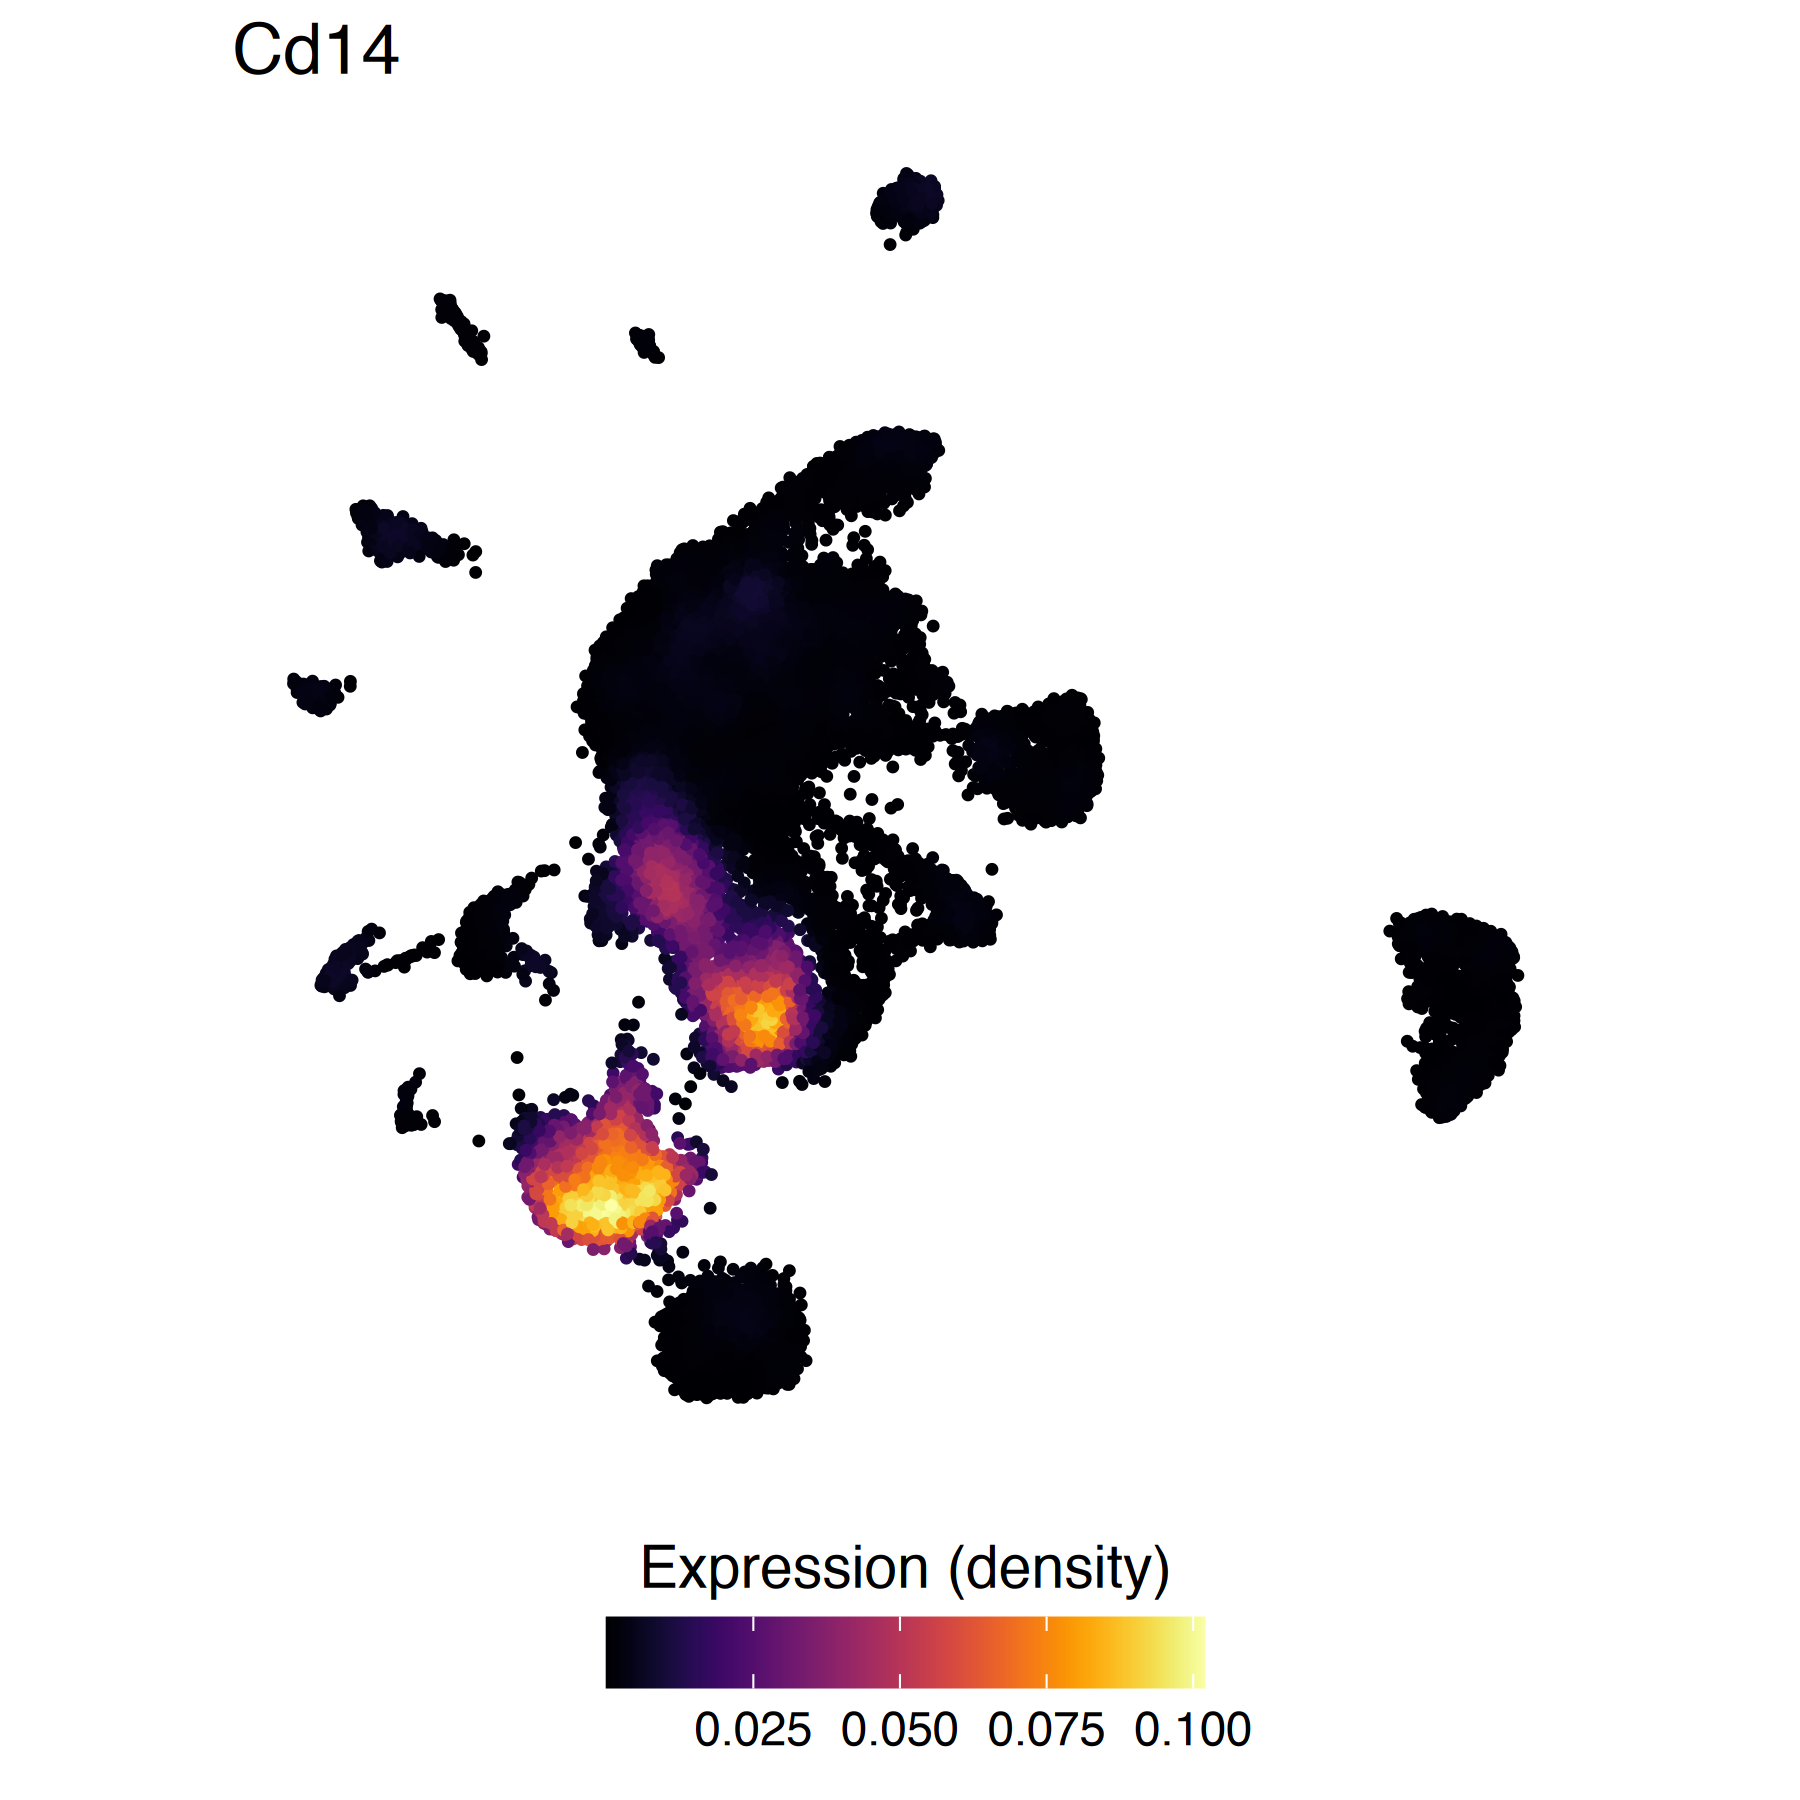

In [13]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)
image <- plot_density(mouse, "Cd14", reduction = "umap", slot = "data") + scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), legend.position = 'bottom',
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank())  + labs(title = "Cd14", color = "Expression (density)") + 
    guides(color = guide_colourbar(title.position = "top", title.hjust=0.5, direction = 'horizontal', barwidth = 10))

image_nolegend <- plot_density(mouse, "Cd14", reduction = "umap", slot = "data") + scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank()) + labs(title = "") + NoLegend()


legend = as_ggplot(ggpubr::get_legend(image))

ggsave(file="outputs/figures/figure3a_cd14.png", plot=image_nolegend, width=5, height=5)
ggsave(file="outputs/figures/figure3a_cd14_legend.svg", plot=legend, width=5, height=5)

image

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


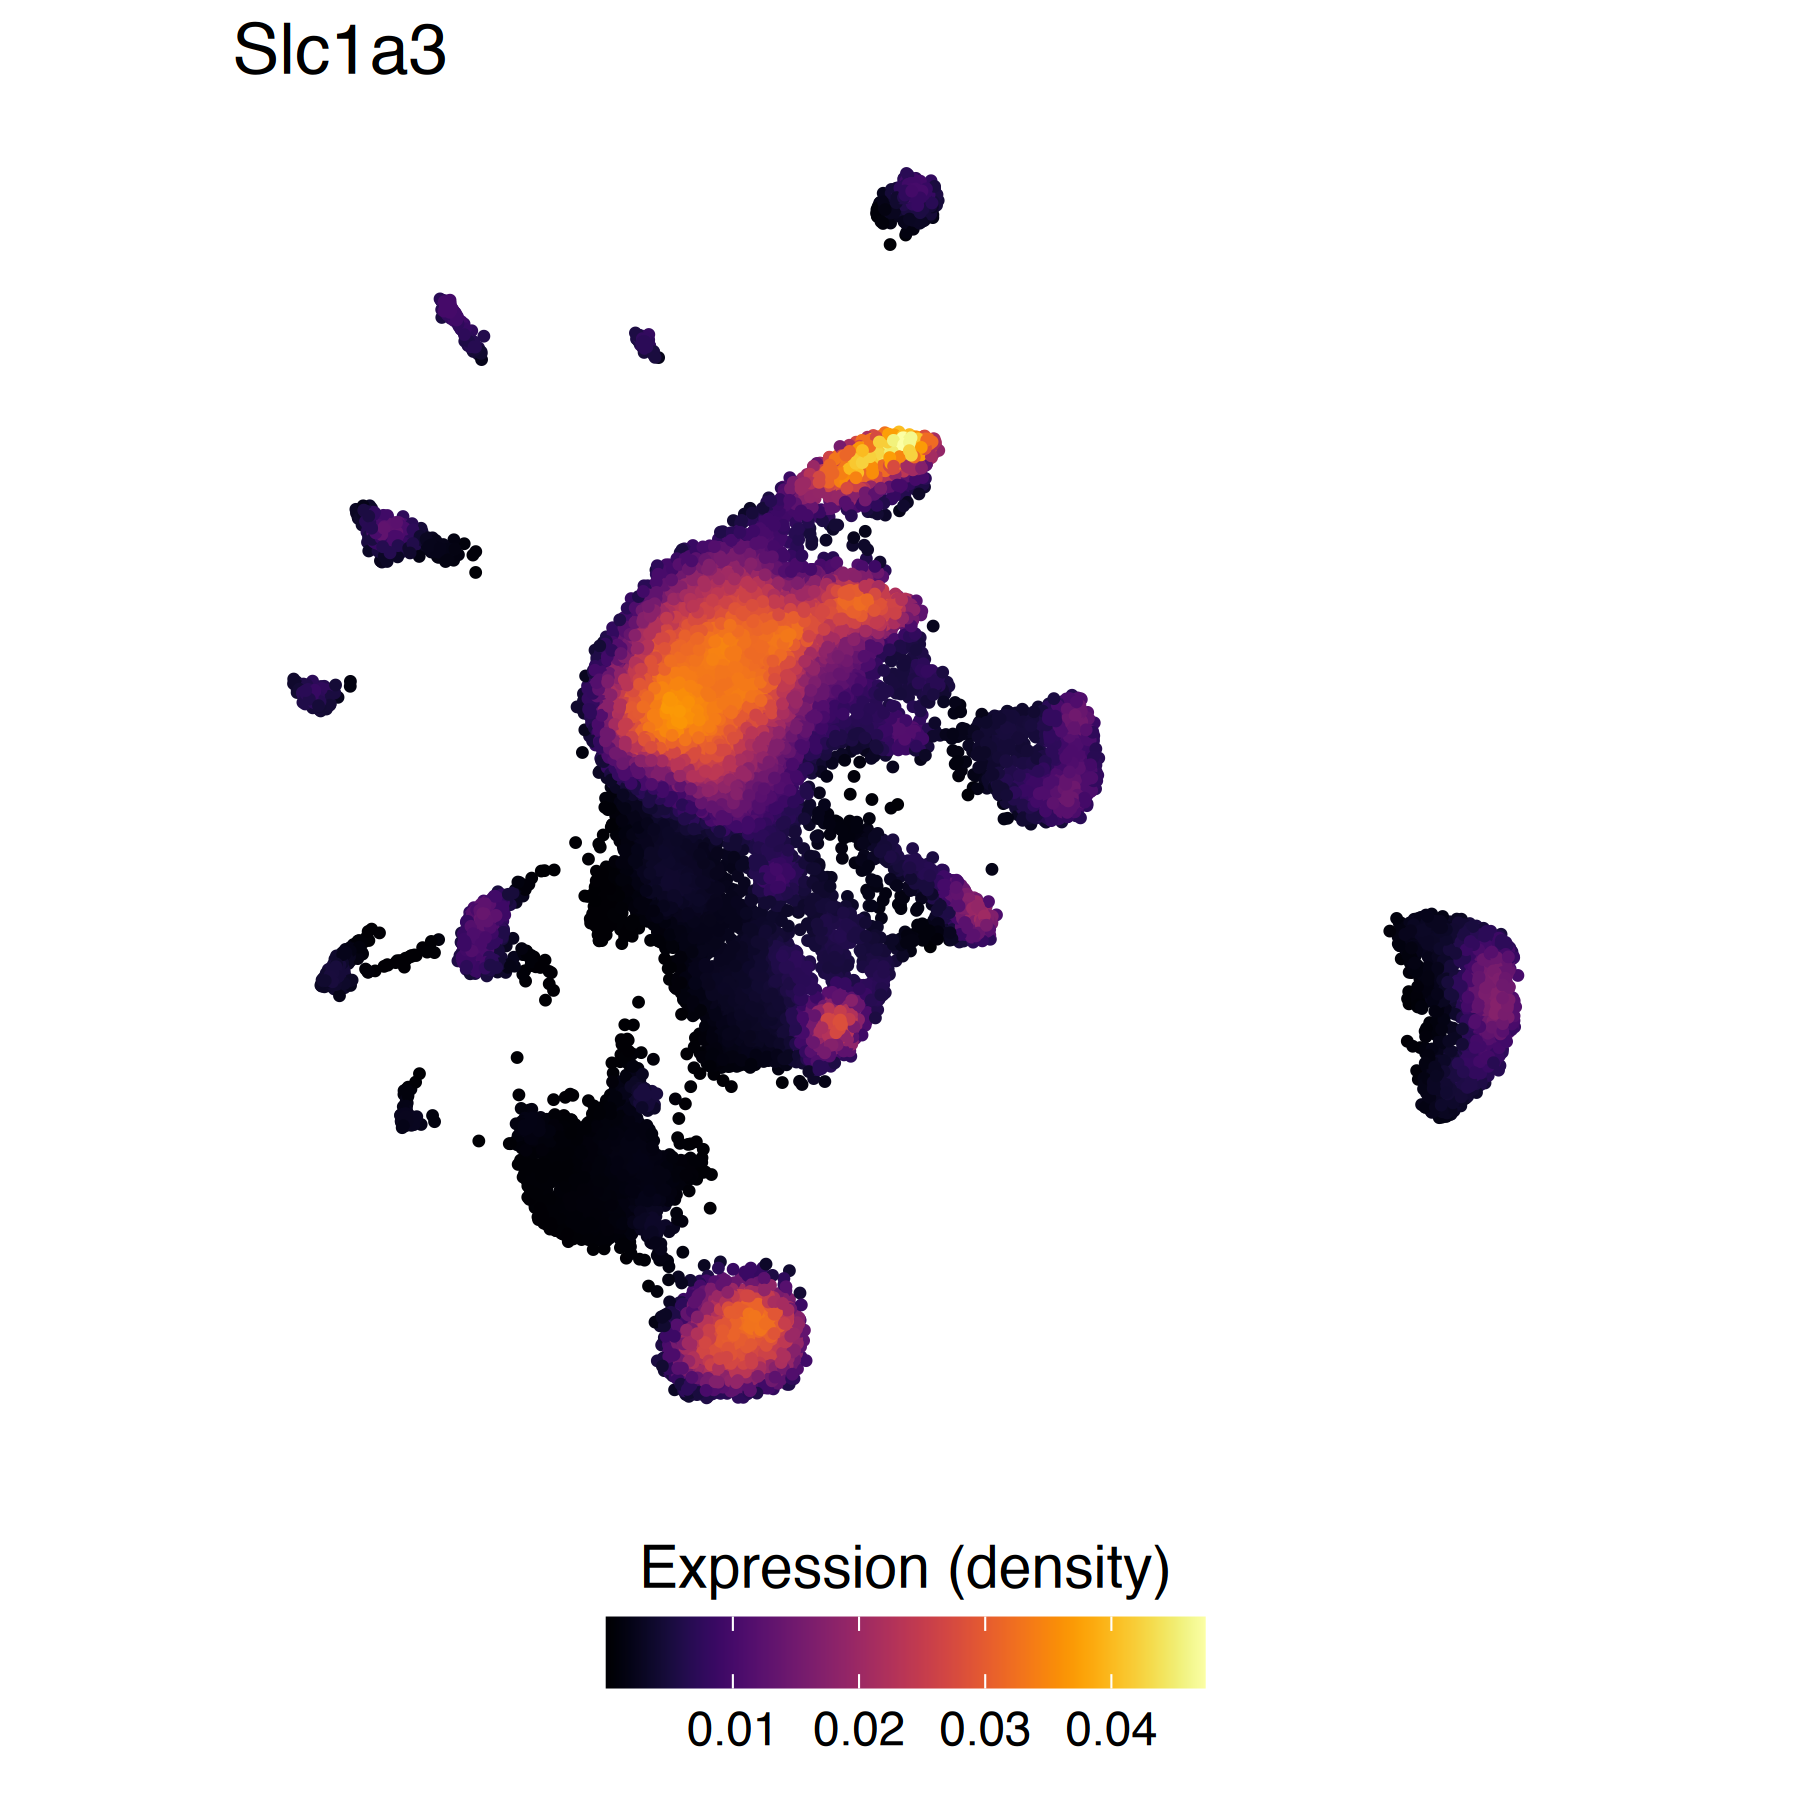

In [14]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)
image <- plot_density(mouse, "Slc1a3", reduction = "umap", slot = "data") + 
    scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), legend.position = 'bottom',
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank())  + labs(title = "Slc1a3", color = "Expression (density)") + 
    guides(color = guide_colourbar(title.position = "top", title.hjust=0.5, direction = 'horizontal', barwidth = 10))

image_nolegend <- plot_density(mouse, "Slc1a3", reduction = "umap", slot = "data") + 
    scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank()) + labs(title = "") + NoLegend()


legend = as_ggplot(ggpubr::get_legend(image))

ggsave(file="outputs/figures/figure3a_slc1a3.png", plot=image_nolegend, width=5, height=5)
ggsave(file="outputs/figures/figure3a_slc1a3_legend.svg", plot=legend, width=5, height=5)

image

We can also see that Cluster 1 (mainly labeled as Cluster 5 in the original Wheeler paper) expresses microglia specific marker genes *Tmem119* and *P2ry12*.

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


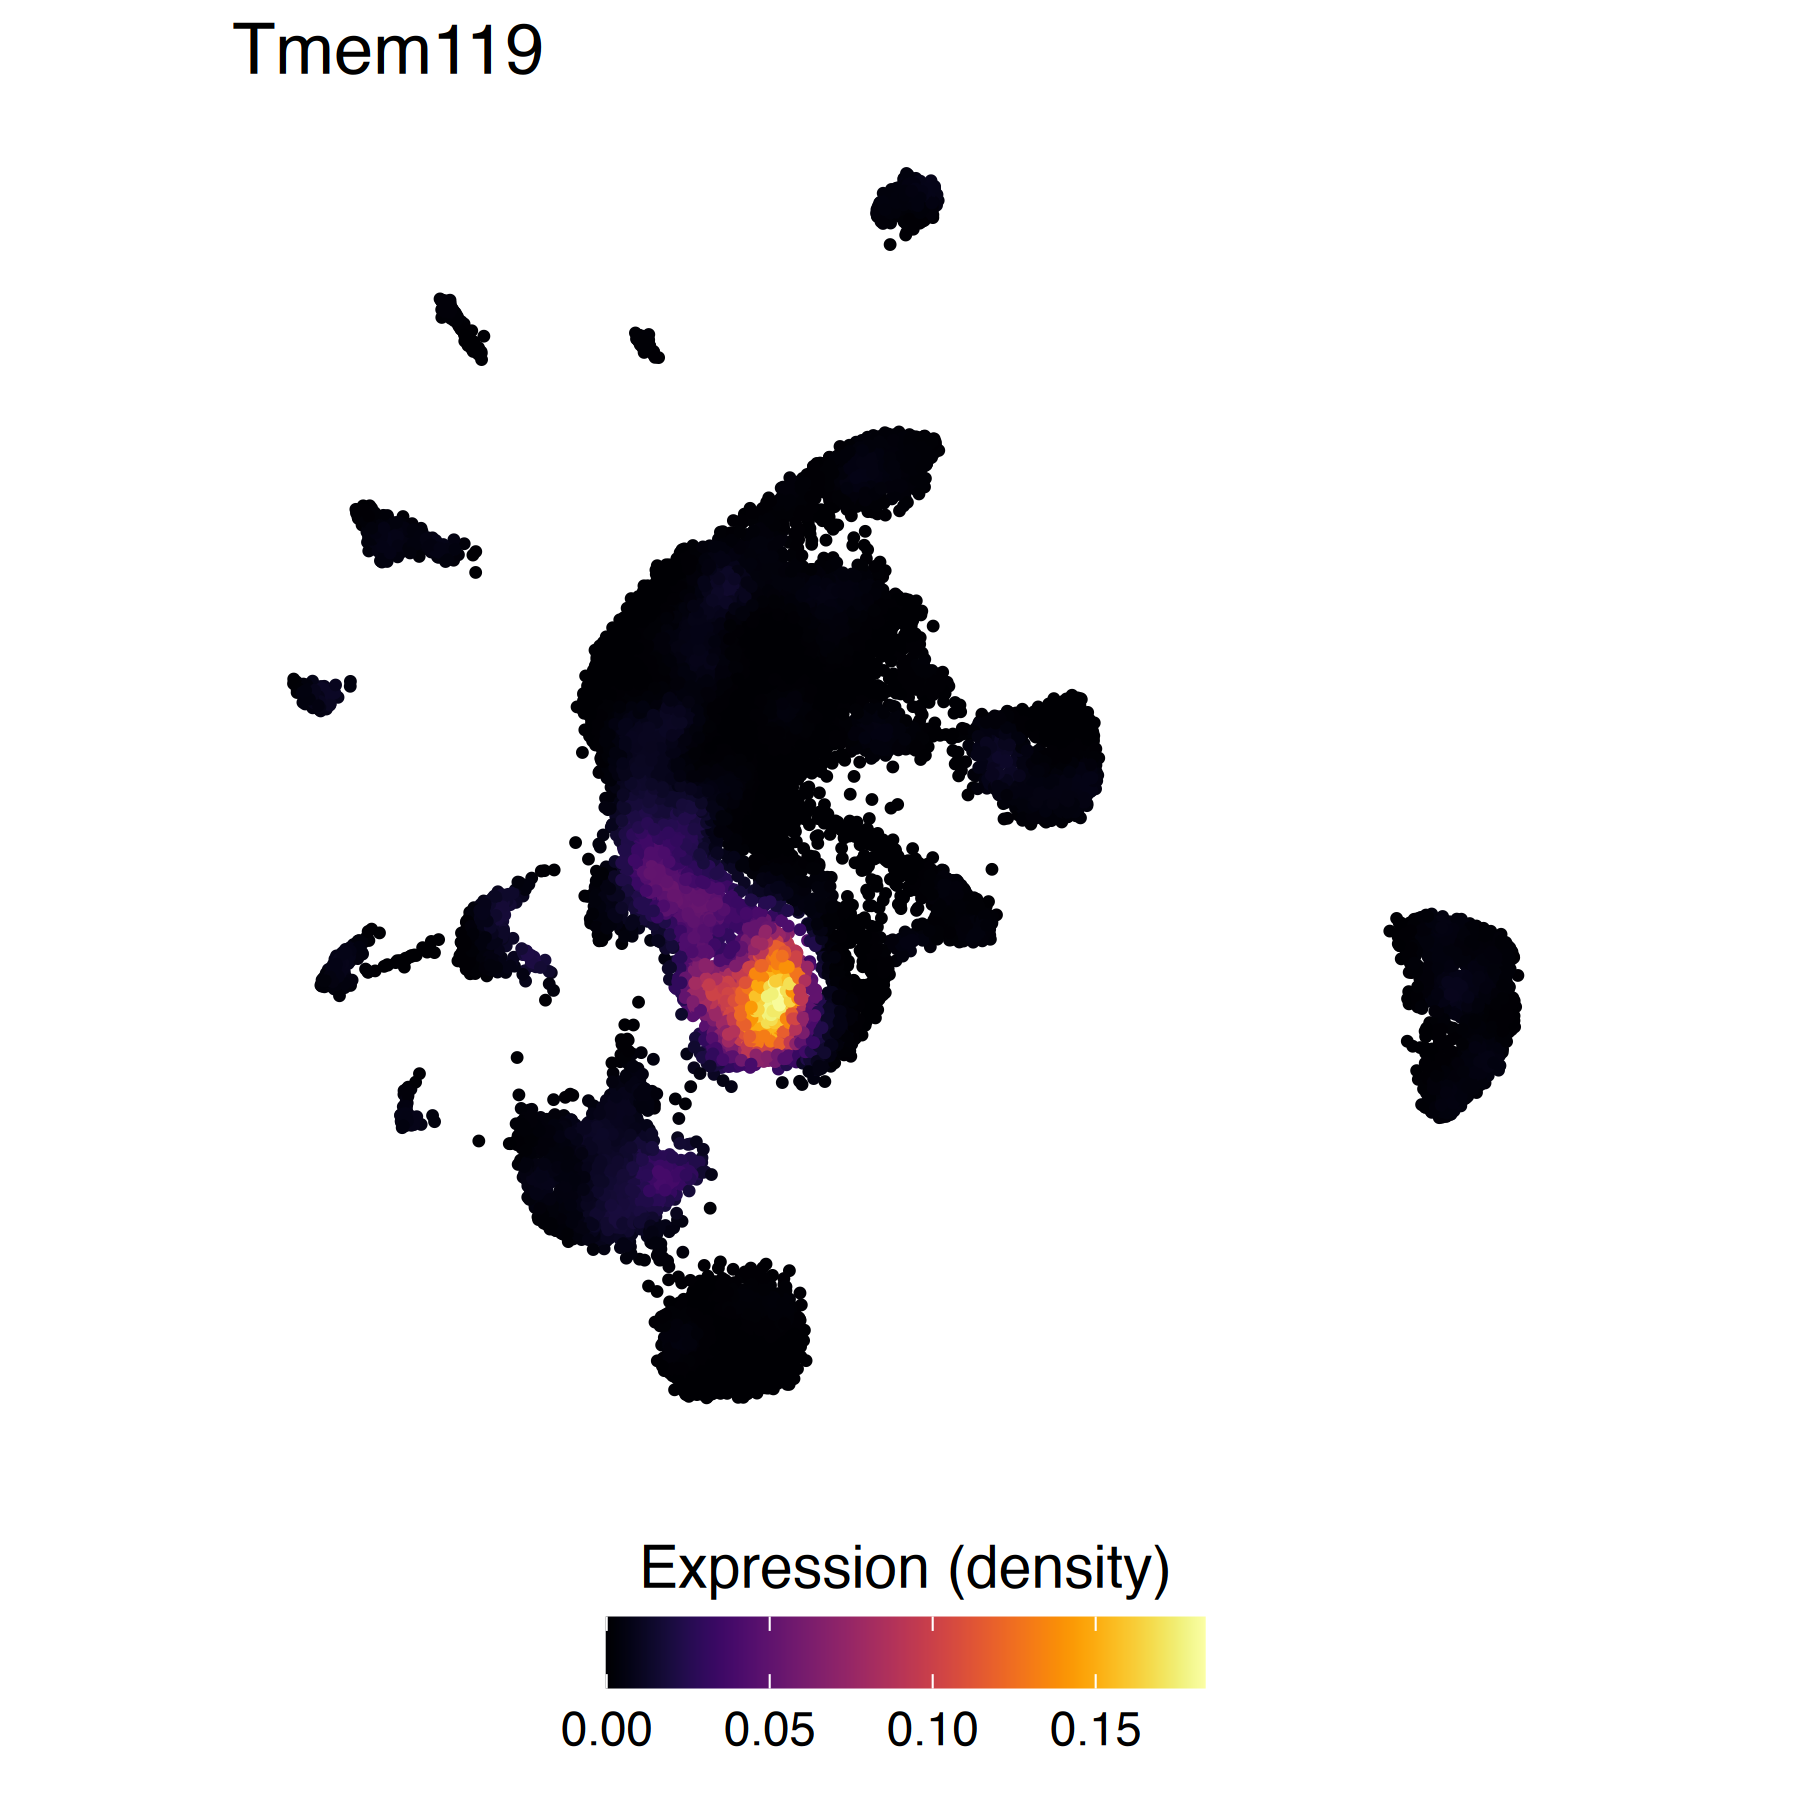

In [15]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)
image <- plot_density(mouse, "Tmem119", reduction = "umap", slot = "data") + scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(), legend.position = 'bottom')  + labs(title = "Tmem119", color = "Expression (density)") + 
    guides(color = guide_colourbar(title.position = "top", title.hjust=0.5, direction = 'horizontal', barwidth = 10))

image_nolegend <- plot_density(mouse, "Tmem119", reduction = "umap", slot = "data") + scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank()) + labs(title = "") + NoLegend()


legend = as_ggplot(ggpubr::get_legend(image))

ggsave(file="outputs/figures/figure3a_tmem119.png", plot=image_nolegend, width=5, height=5)
ggsave(file="outputs/figures/figure3a_tmem119_legend.svg", plot=legend, width=5, height=5)

image

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


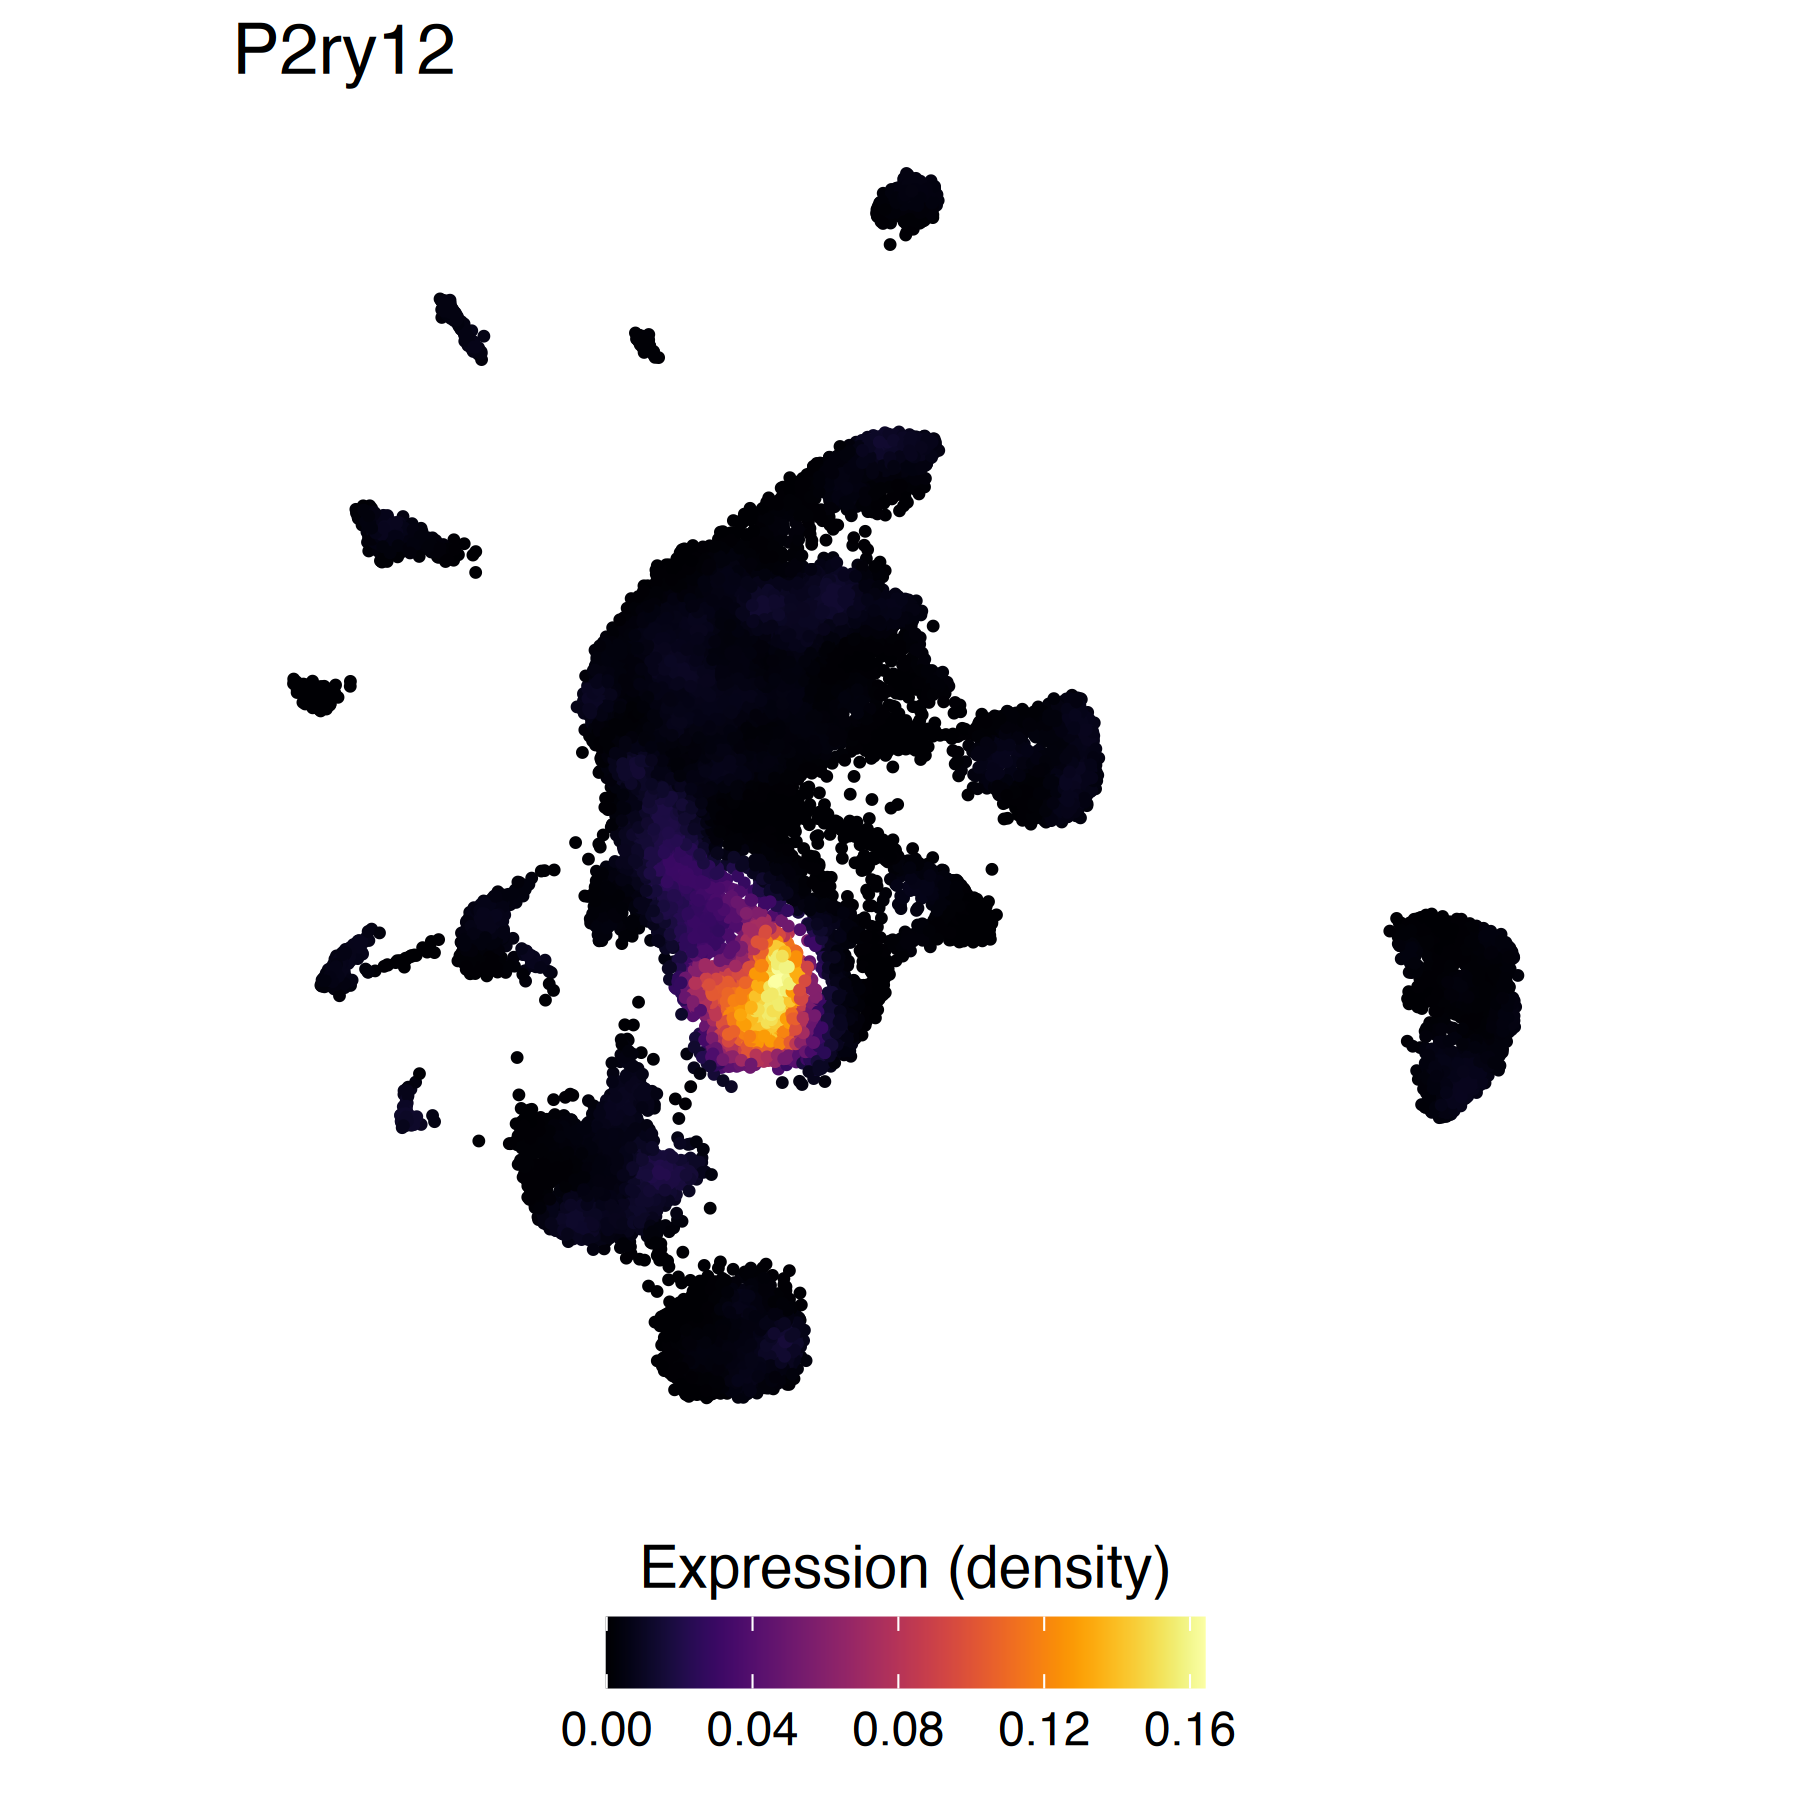

In [16]:
options(repr.plot.width=6, repr.plot.height=6, repr.plot.res = 300)
image <- plot_density(mouse, "P2ry12", reduction = "umap", slot = "data") + scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), legend.position = 'bottom',
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank())  + labs(title = "P2ry12", color = "Expression (density)") + 
    guides(color = guide_colourbar(title.position = "top", title.hjust=0.5, direction = 'horizontal', barwidth = 10))

image_nolegend <- plot_density(mouse, "P2ry12", reduction = "umap", slot = "data") + scale_color_viridis(option = "inferno") +
    theme(aspect.ratio = 1, axis.line = element_blank(), 
          axis.ticks = element_blank(), axis.title = element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank()) + labs(title = "") + NoLegend()


legend = as_ggplot(ggpubr::get_legend(image))

ggsave(file="outputs/figures/figure3a_p2ry12.png", plot=image_nolegend, width=5, height=5)
ggsave(file="outputs/figures/figure3a_p2ry12_legend.svg", plot=legend, width=5, height=5)

image

Recapitulating Lee et al's findings, we see that both the cytokine treatment experiment derived 'Up-Signature' and the FIND-seq derived signature are most highly expressed by Clusters 3, 1, and 10; however these clusters exhibit expression of macrophage, microglia, and T cell marker genes.

In [17]:
signatures = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM4_ESM.xlsx')
up_signature = signatures %>% filter(log2FoldChange > 0) %>% .$gene

findseq = read_excel('inputs/zenodo/supplementary_tables/41586_2024_7187_MOESM10_ESM.xlsx', col_names = FALSE)
findseq = findseq$`...1`

mouse <- AddModuleScore(mouse, features = list(up_signature, findseq), name = 'SIGNATURE')

New names:
• `` -> `...1`
Warning message:
“The following features are not present in the object: Ubb-ps, Ecrg4, H2az1, Aopep, Gm48942, Rpl15-ps3, Rps12-ps3, Gm29408, Gm5641, Rps7-ps3, Gm20400, Gm29371, Gm12505, Gm48377, Gm47922, 1700030N03Rik, Gm45551, Gm42031, CT868690.1, Reg3g, Nlrp12, AC241534.1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: 1700110I01Rik, AC113595.1, Gm10062, Gm19220, Gm22146, Gm25190, Gm25197, Gm25735, Gm28017, Gm38152, Gm38302, Gm43540, Gm43652, Gm47031, Gm47164, Gm47551, Gm47578, Gm47673, Gm48216, Gm48269, Gm48271, Gm48309, Gm48600, Gm48610, Gm48942, Gm6899, Olfr907, Rpl15-ps3, Rps12-ps3, Septin11, Ubb-ps, not searching for symbol synonyms”


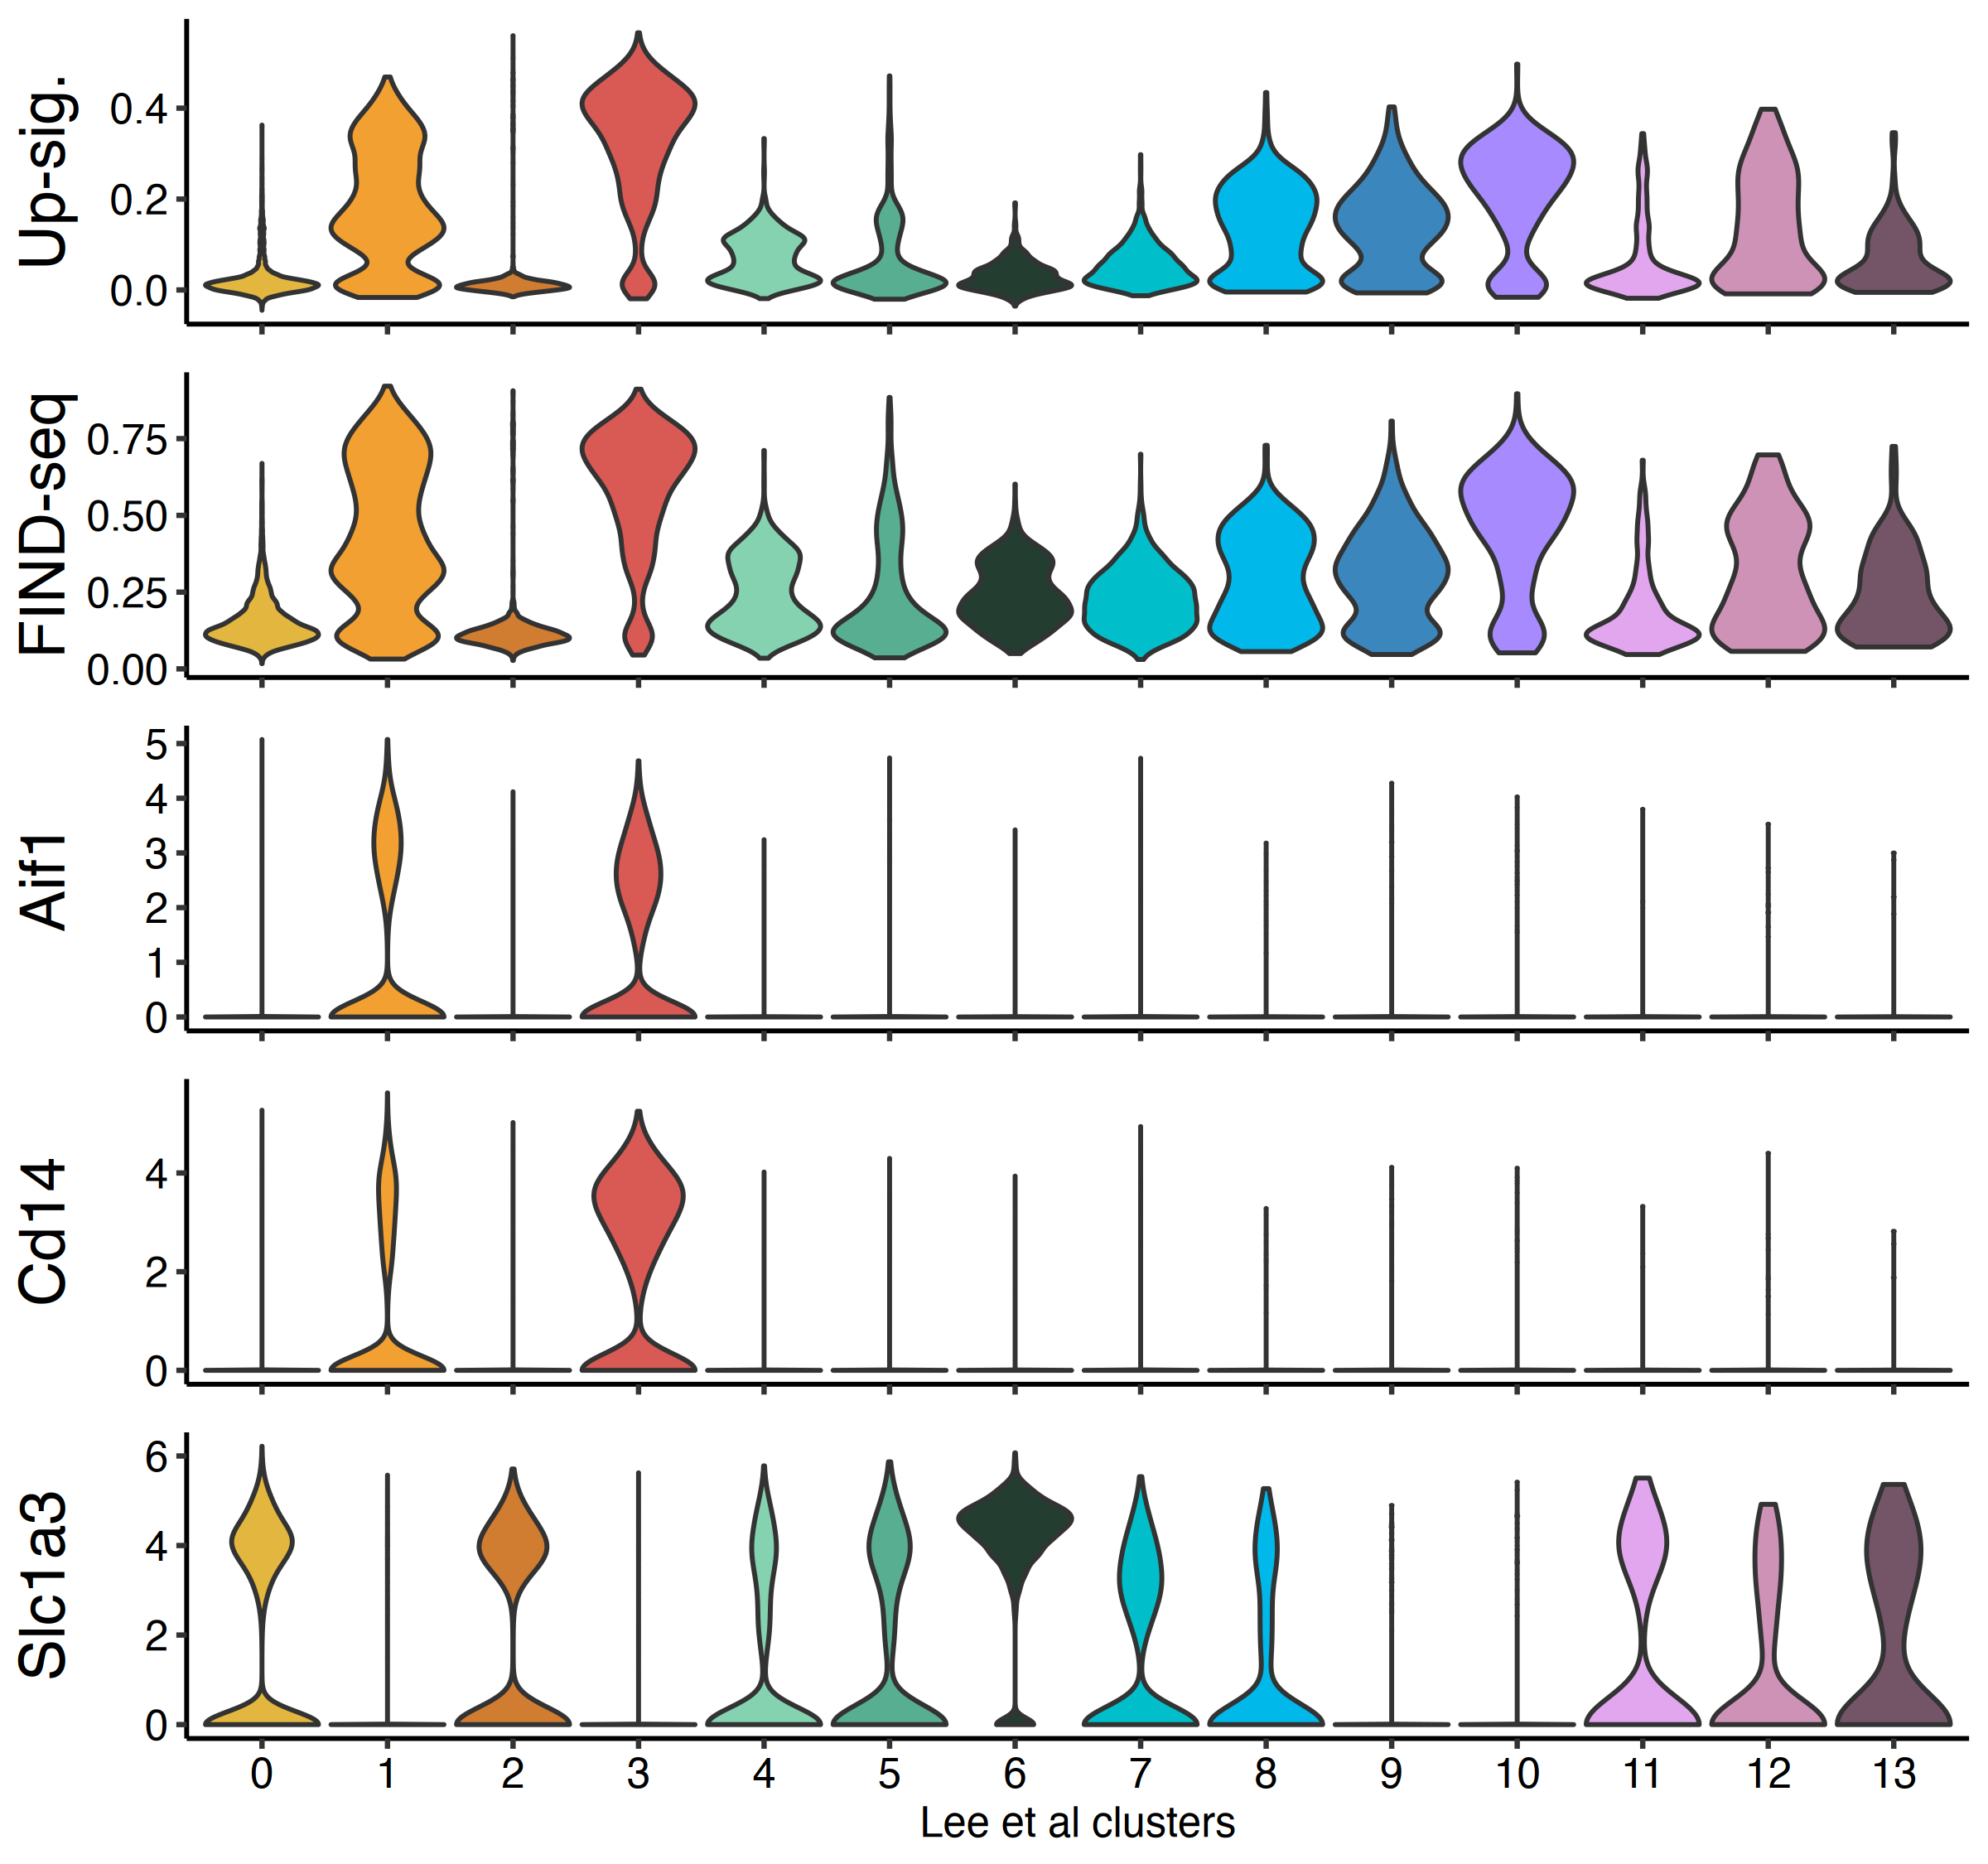

In [18]:
options(repr.plot.width=8, repr.plot.height=7.5, repr.plot.res = 300)

p1 = VlnPlot(mouse, features="SIGNATURE1", pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + 
    theme_pubr() + NoLegend() + labs(x = NULL, y = "Up-sig.", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

p2 = VlnPlot(mouse, features="SIGNATURE2", pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + 
    theme_pubr() + NoLegend() + labs(x = NULL, y = "FIND-seq", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold'))

p3 = VlnPlot(mouse, features="Aif1", pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + 
    theme_pubr() + NoLegend() + labs(x = NULL, y = "Aif1", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold.italic'))

p4 = VlnPlot(mouse, features="Cd14", pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + 
    theme_pubr() + NoLegend() + labs(x = NULL, y = "Cd14", title=NULL) + theme(axis.text.x = element_blank(), plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold.italic'))

p5 = VlnPlot(mouse, features='Slc1a3', pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + 
    theme_pubr() + NoLegend() + labs(x = "Lee et al clusters", y = "Slc1a3", title=NULL) + theme(plot.margin = unit(c(0, 0, 0, 0), 'mm'), axis.title.y = element_text(size = 18, face = 'bold.italic'))

image = plot_grid(p1, NULL, p2, NULL, p3, NULL, p4, NULL, p5, ncol = 1, align = 'v', rel_heights = c(1, 0, 1, 0, 1, 0, 1, 0, 1.275))

ggsave(file="outputs/figures/figure3c.svg", plot=image, width=8, height=7.5)

image

We also note that the proportion of UMIs mapping to mitochondrial genome genes is extremely elevated in Cluster 2, indicating this cluster corresponds to damaged, dying, or otherwise low quality cells. 

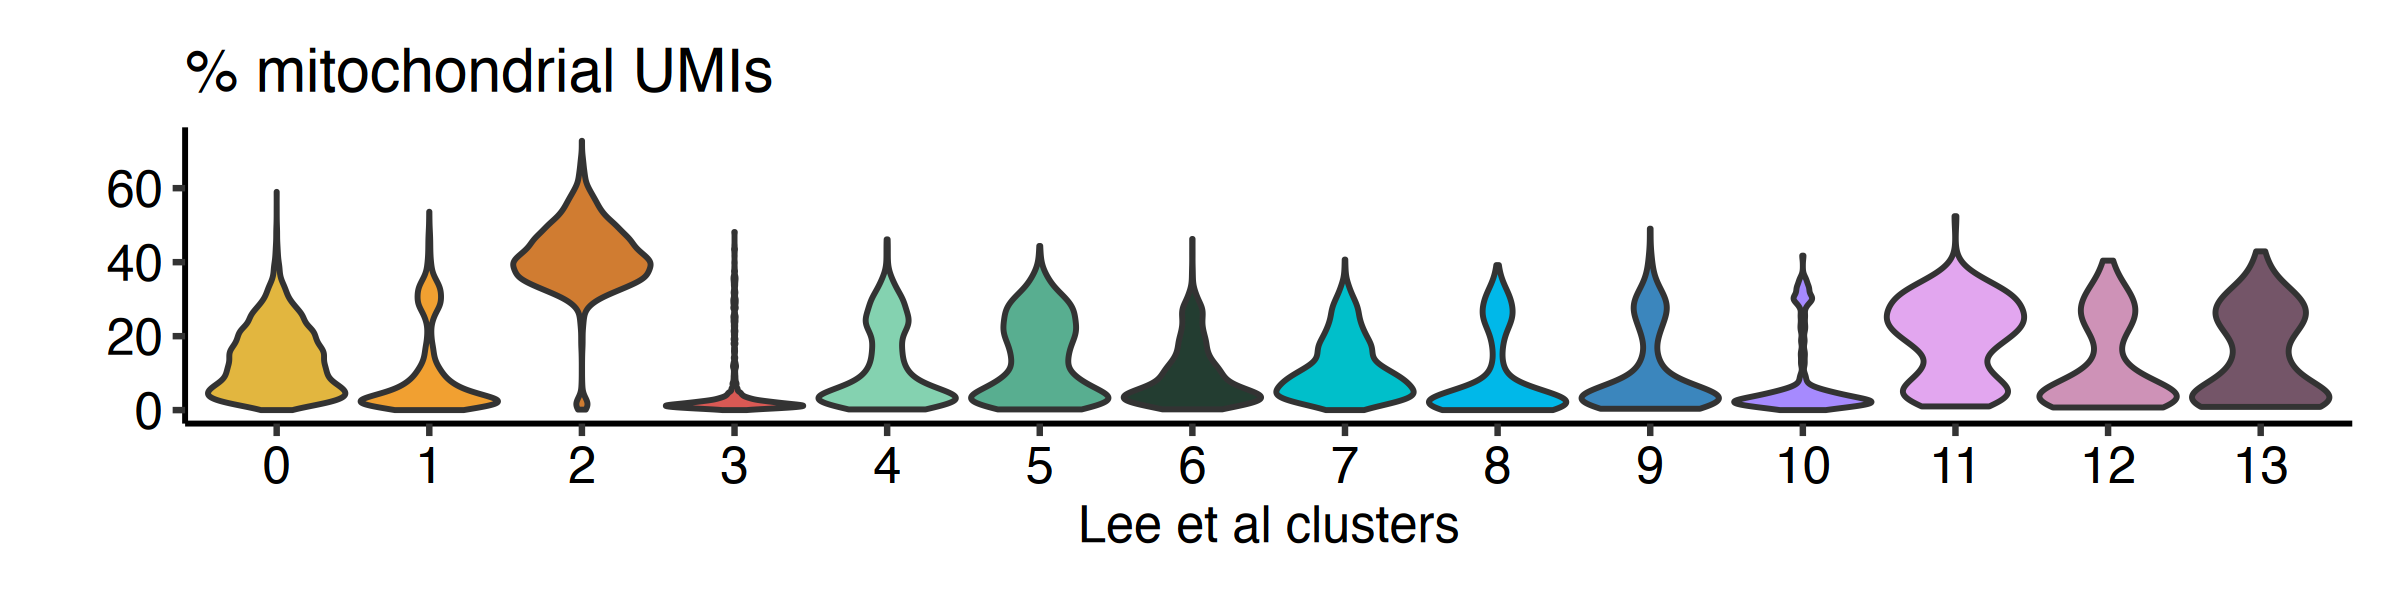

In [19]:
options(repr.plot.width=8, repr.plot.height=2, repr.plot.res = 300)
mouse[["percent.mt"]] <- PercentageFeatureSet(object = mouse, pattern = "^mt-")

VlnPlot(mouse, features="percent.mt", pt.size = 0)  + 
    scale_fill_manual(values = c("#e2b63f", "#f1a031", "#d07c31", "#d95954", "#84d2b0",
                                 "#58ae90", "#233d31", "#00bfca", "#00b8e9", "#3b86bd", 
                                  "#a68afe", "#e2a6ef", "#ce92b7", "#745568"
                                 )) + 
    theme_pubr() + NoLegend() + labs(x = "Lee et al clusters", title = "% mitochondrial UMIs", y = "")

Plotting canonical cell type marker genes in a dot plot reveals that many clusters are likely non-astrocyte cell types. Expression of astrocyte genes in these clusters may be due to ambient RNA or doublets/multiplets.

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


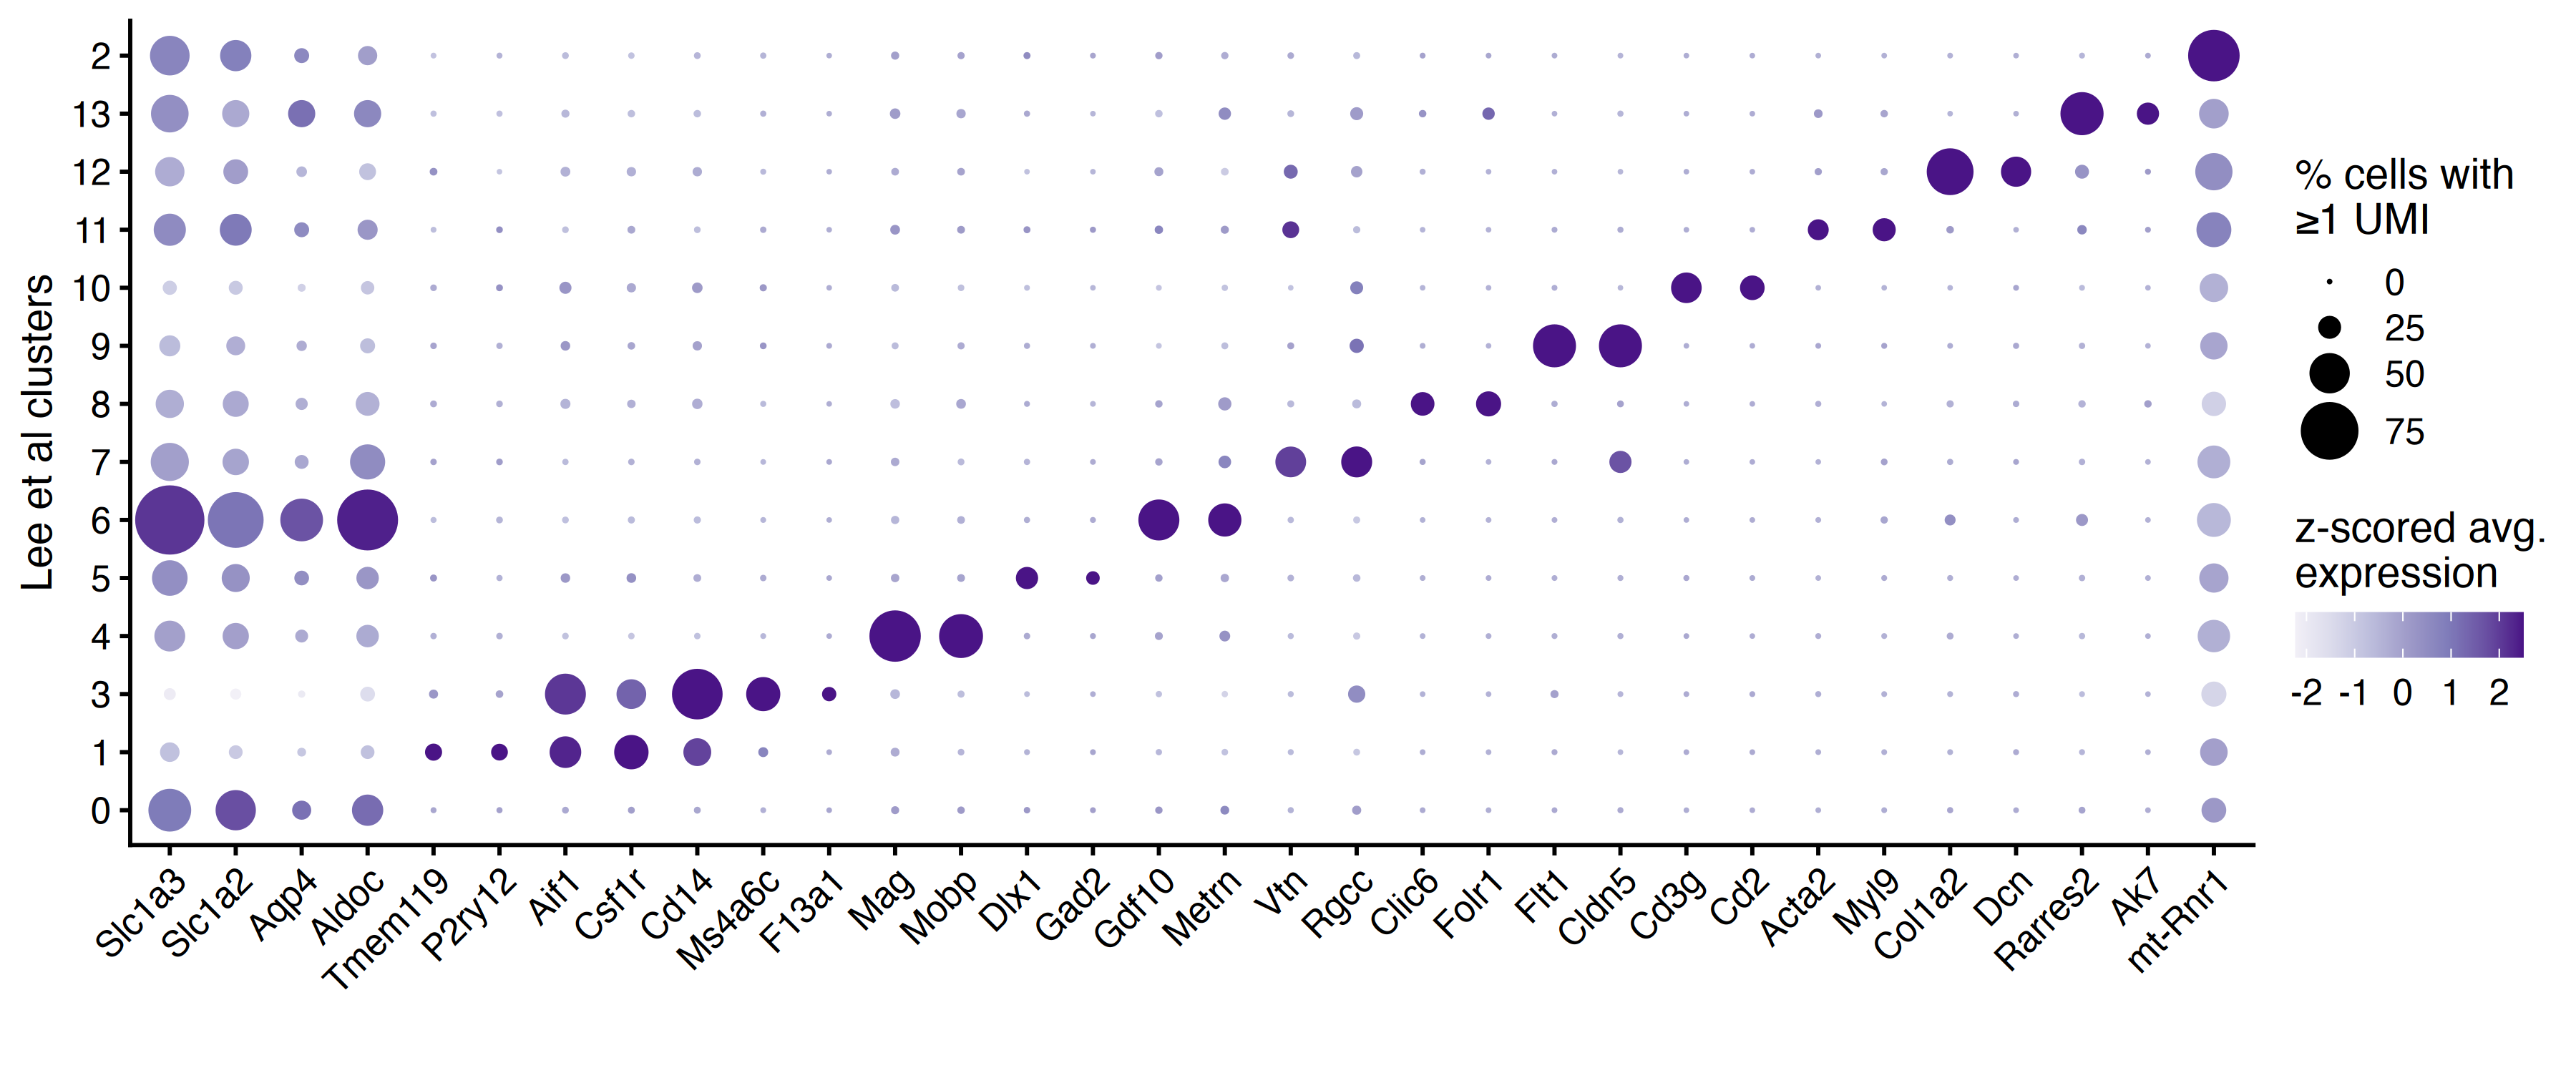

In [20]:
options(repr.plot.width=12, repr.plot.height=5, repr.plot.res = 300, warn = -1)

mouse$cluster_reordered <- factor(Idents(mouse), levels = c('0', '1', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '2'))

image = DotPlot(mouse, features = c('Slc1a3', 'Slc1a2', 'Aqp4', 'Aldoc',
                            'Tmem119', 'P2ry12','Aif1', 'Csf1r', 'Cd14',
                            'Ms4a6c','F13a1',
                            'Mag', 'Mobp',
                            'Dlx1', 'Gad2',
                            'Gdf10', 'Metrn',
                            'Vtn','Rgcc',
                            'Clic6', 'Folr1',
                           'Flt1','Cldn5',
                            'Cd3g','Cd2', 
                            'Acta2','Myl9', 
                           'Col1a2', 'Dcn',
                           'Rarres2', 'Ak7', 
                           'mt-Rnr1'), scale = TRUE,
       dot.scale = 10, group.by = 'cluster_reordered') + 
    labs(x = "", y = "Lee et al clusters", color = "avg. z-score\nexpression") + scale_color_distiller(palette = 'Purples', direction = 1) + 
    scale_y_discrete() + 
    guides(color = guide_colorbar(title = 'z-scored avg.\nexpression', direction = "horizontal", title.position = "top"),
          size = guide_legend(title = "% cells with\n≥1 UMI")) + 
    theme(axis.text.x = element_text(angle = 45, hjust=1, face = 'italic'))

ggsave(file="outputs/figures/figure3d.svg", plot=image, width=12, height=5, dpi = 600)

image

options(warn = 0)

Lastly, we will produce two output files which will be needed in the Step 10 script: a raw count matrix CSV file and a text file containing the cluster labels for each cell.

In [21]:
write.csv(as.matrix(LayerData(mouse, layer = 'counts')), "outputs/mouse_count_matrix.csv")
write.table(mouse$seurat_clusters, "outputs/wheeler_cluster_labels.txt", row.names = FALSE, col.names = FALSE, quote = FALSE, sep = "\n")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.6 GiB”


In [22]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/liddelowlab/mambaforge/envs/EpiMemAstros/lib/libopenblasp-r0.3.28.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: system (macOS)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.3      ggrastr_1.0.2      ggrepel_0.9.6      presto_1.0.0      
 [5] data.table_1.15.4  Rcpp_1.0.13-1      viridis_0.6.5      viridisLite_0.4.2 
 [9] Nebulosa_1.12.0    patchwork_1.3.0    dplyr_1.1.4        ggsci_3.2.0       
[13] ggpubr_0.6.0       ggplot2_3.5.1      readxl_1.4.3       Seurat_5.1.0      
[17] SeuratObject_5.0.2 sp_2.1-4          

loaded via a namespace (and not attached):
  [1] RcppAnnoy_0.0.22            splines_4.3.3              
  [3] later_1

In [23]:
version

               _                           
platform       x86_64-apple-darwin13.4.0   
arch           x86_64                      
os             darwin13.4.0                
system         x86_64, darwin13.4.0        
status                                     
major          4                           
minor          3.3                         
year           2024                        
month          02                          
day            29                          
svn rev        86002                       
language       R                           
version.string R version 4.3.3 (2024-02-29)
nickname       Angel Food Cake             